In [45]:
import pandas as pd
from torch.nn.utils.rnn import pad_sequence
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [46]:
# Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨ Ìï®ÏàòÎì§
def df_treat(name):
    """Îç∞Ïù¥ÌÑ∞ Ï†ïÍ∑úÌôî Î∞è Ï†ÑÏ≤òÎ¶¨"""
    df = pd.read_csv(name)
    ndf = pd.DataFrame()
    range_mm={
        'V': {'min':df['V'].min()*0.8, 'max': df['V'].max()*1.2},
        'E': {'min':df['E'].min()*0.8, 'max': df['E'].max()*1.2},
        'VF': {'min':df['VF'].min()*0.8, 'max': df['VF'].max()*1.2},
        'VA': {'min':df['VA'].min()*0.8, 'max': df['VA'].max()*1.2},
        'VB': {'min':df['VB'].min()*0.8, 'max': df['VB'].max()*1.2},
        'CFLA': {'min':0, 'max': df['CFLA'].max()*1.2},
        'CALA': {'min':0, 'max': df['CALA'].max()*1.2},
        'CFK': {'min':0, 'max': df['CFK'].max()*1.2},
        'CBK': {'min':0, 'max': df['CBK'].max()*1.2},
        'I': {'min':0, 'max': df['I'].max()*1.2},
    }
    ndf['exp'] = df['exp']; ndf['t'] = df['t']

    for col in ['V', 'E', 'VF', 'VA', 'VB', 'CFLA', 'CALA', 'CFK', 'CBK', 'I']:
        if col in range_mm:
            ndf[col] = (df[col] - range_mm[col]['min'])/(range_mm[col]['max'] - range_mm[col]['min'])
        else:
            ndf[col] = df[col]

    exp_num_list = sorted(ndf['exp'].unique())
    return df, ndf, range_mm, exp_num_list

def seq_data(ndf, exp_num_list):
    """ÏãúÌÄÄÏä§ Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ±"""
    seq = []
    feature_cols = ['V', 'E', 'VF', 'VA', 'VB', 'CFLA', 'CALA', 'CFK', 'CBK', 'I']
    
    for exp in exp_num_list:
        exp_df = ndf[ndf['exp'] == exp]
        seq.append(exp_df[feature_cols].values)
    
    return seq

def pad_seq(seq):
    """ÏãúÌÄÄÏä§ Ìå®Îî©"""
    max_len = max([len(s) for s in seq])
    seq_len = [len(s) for s in seq]
    pad_seq = pad_sequence([torch.tensor(s) for s in seq], batch_first=True, padding_value=-1)
    return pad_seq, seq_len, max_len

def gen_dataset(pad_seq, seq_len):
    """Îç∞Ïù¥ÌÑ∞ÏÖã ÏÉùÏÑ±"""
    input_tensor = pad_seq.float()
    seq_len_tensor = torch.tensor(seq_len)
    dataset = TensorDataset(input_tensor, seq_len_tensor)
    return dataset

In [47]:
# Î™®Îç∏ ÌÅ¥ÎûòÏä§ Ï†ïÏùò (Í∏∞Ï°¥ ÌïôÏäµÎêú Î™®Îç∏Í≥º ÎèôÏùºÌïú Íµ¨Ï°∞)

class LayerNormLSTM(nn.Module):
    """LSTM layer with layer normalization applied to gates"""
    def __init__(self, input_node, hidden_node):
        super().__init__()
        self.input_node = input_node
        self.hidden_node = hidden_node

        self.w_i = nn.Linear(input_node, 4 * hidden_node, bias=False)
        self.w_h = nn.Linear(hidden_node, 4 * hidden_node, bias=False)

        self.ln_i = nn.LayerNorm(hidden_node)
        self.ln_h = nn.LayerNorm(hidden_node)
        self.ln_g = nn.LayerNorm(hidden_node)
        self.ln_o = nn.LayerNorm(hidden_node)

        self.ln_c = nn.LayerNorm(hidden_node)

    def forward(self, input, hidden):
        h_prev, c_prev = hidden

        gi = self.w_i(input)
        gh = self.w_h(h_prev)
        i_i, i_f, i_g, i_o = gi.chunk(4, dim=-1)
        h_i, h_f, h_g, h_o = gh.chunk(4, dim=-1)

        i_g = torch.sigmoid(self.ln_i(i_i + h_i))
        f_g = torch.sigmoid(self.ln_h(i_f + h_f))
        g_g = torch.tanh(self.ln_g(i_g + h_g))
        o_g = torch.sigmoid(self.ln_o(i_o + h_o))

        c_new = f_g * c_prev + i_g * g_g
        c_new = self.ln_c(c_new)

        h_new = o_g * torch.tanh(c_new)

        return h_new, c_new
class StateExtr(nn.Module):
    """State Extractor using LayerNorm LSTM"""
    def __init__(self, input_node, hidden_node, n_layer, dropout):
        super().__init__()
        self.hidden_node = hidden_node
        self.n_layer = n_layer
        self.input_node = input_node

        self.lstm_cells = nn.ModuleList()
        self.lstm_cells.append(LayerNormLSTM(input_node, hidden_node))

        for _ in range(n_layer - 1):
            self.lstm_cells.append(LayerNormLSTM(hidden_node, hidden_node))

        self.dropout = nn.Dropout(dropout)
        self.final_layer_norm = nn.LayerNorm(hidden_node)
        self.final_dropout = nn.Dropout(dropout)

    def forward(self, x, seq_len):
        batch_size, max_len, input_node = x.size()
        device = x.device

        h_states = []
        c_states = []
        for _ in range(self.n_layer):
            h_states.append(torch.zeros(batch_size, self.hidden_node, device=device))
            c_states.append(torch.zeros(batch_size, self.hidden_node, device=device))
        
        outputs = []
        for t in range(max_len):
            x_t = x[:, t, :]

            layer_input = x_t
            for layer_idx, lstm_cell in enumerate(self.lstm_cells):
                h_new, c_new = lstm_cell(layer_input, (h_states[layer_idx], c_states[layer_idx]))

                h_states[layer_idx] = h_new
                c_states[layer_idx] = c_new

                if layer_idx < len(self.lstm_cells) - 1:
                    layer_input = self.dropout(h_new)
                else:
                    layer_input = h_new

            outputs.append(layer_input)
        
        output_tensor = torch.stack(outputs, dim=1)
        seq_len_cpu = seq_len.detach().cpu().long()
        mask = torch.arange(max_len, device='cpu')[None, :] < seq_len_cpu[:, None]
        mask = mask.float().to(device).unsqueeze(-1)

        masked_output = output_tensor * mask
        normalized = self.final_layer_norm(masked_output)
        return self.final_dropout(normalized)

# Stateful State Extractor for Free Running Model
class StatefulStateExtr(nn.Module):
    """Hidden stateÎ•º Ïú†ÏßÄÌïòÎ©∞ sequential Ï≤òÎ¶¨ÌïòÎäî State Extractor"""
    def __init__(self, input_node, hidden_node, n_layer, dropout):
        super().__init__()
        self.hidden_node = hidden_node
        self.n_layer = n_layer
        self.input_node = input_node

        self.lstm_cells = nn.ModuleList()
        self.lstm_cells.append(LayerNormLSTM(input_node, hidden_node))

        for _ in range(n_layer - 1):
            self.lstm_cells.append(LayerNormLSTM(hidden_node, hidden_node))

        self.dropout = nn.Dropout(dropout)
        self.final_layer_norm = nn.LayerNorm(hidden_node)
        self.final_dropout = nn.Dropout(dropout)
        
        # Hidden statesÎ•º ÌÅ¥ÎûòÏä§ Î≥ÄÏàòÎ°ú Í¥ÄÎ¶¨
        self.h_states = None
        self.c_states = None

    def reset_states(self, batch_size=None, device=None):
        """ÏÉàÎ°úÏö¥ ÏãúÌÄÄÏä§ ÏãúÏûë Ïãú hidden state Ï¥àÍ∏∞Ìôî"""
        if batch_size is not None and device is not None:
            self.h_states = []
            self.c_states = []
            for _ in range(self.n_layer):
                self.h_states.append(torch.zeros(batch_size, self.hidden_node, device=device))
                self.c_states.append(torch.zeros(batch_size, self.hidden_node, device=device))
        else:
            self.h_states = None
            self.c_states = None

    def forward_single_timestep(self, x_t):
        """Îã®Ïùº ÏãúÏ†ê Ï≤òÎ¶¨ - hidden state Ïú†ÏßÄ"""
        batch_size = x_t.size(0)
        device = x_t.device
        
        # Ï≤´ Î≤àÏß∏ Ìò∏Ï∂ú Ïãú hidden state Ï¥àÍ∏∞Ìôî
        if self.h_states is None:
            self.reset_states(batch_size, device)

        layer_input = x_t
        for layer_idx, lstm_cell in enumerate(self.lstm_cells):
            h_new, c_new = lstm_cell(layer_input, (self.h_states[layer_idx], self.c_states[layer_idx]))

            # Hidden state ÏóÖÎç∞Ïù¥Ìä∏
            self.h_states[layer_idx] = h_new
            self.c_states[layer_idx] = c_new

            if layer_idx < len(self.lstm_cells) - 1:
                layer_input = self.dropout(h_new)
            else:
                layer_input = h_new

        # Ï†ïÍ∑úÌôî Î∞è ÎìúÎ°≠ÏïÑÏõÉ Ï†ÅÏö©
        normalized = self.final_layer_norm(layer_input)
        return self.final_dropout(normalized)

    def forward(self, x, seq_len):
        """Í∏∞Ï°¥ teacher forcing Î∞©ÏãùÍ≥º Ìò∏ÌôòÏÑ± Ïú†ÏßÄ"""
        batch_size, max_len, input_node = x.size()
        device = x.device

        # Teacher forcing Î™®ÎìúÏóêÏÑúÎäî Îß§Î≤à hidden state Ï¥àÍ∏∞Ìôî
        self.reset_states(batch_size, device)
        
        outputs = []
        for t in range(max_len):
            x_t = x[:, t, :]
            output = self.forward_single_timestep(x_t)
            outputs.append(output)
        
        output_tensor = torch.stack(outputs, dim=1)
        
        # ÎßàÏä§ÌÇπ Ï†ÅÏö©
        seq_len_cpu = seq_len.detach().cpu().long()
        mask = torch.arange(max_len, device='cpu')[None, :] < seq_len_cpu[:, None]
        mask = mask.float().to(device).unsqueeze(-1)

        masked_output = output_tensor * mask
        return masked_output

In [48]:
class PhysicalChangeDecoder(nn.Module):
    """Physical Change Decoder"""
    def __init__(self, input_node, output_node, n_layer, hidden_node, dropout):
        super().__init__()

        self.layers = nn.ModuleList()

        self.layers.append(nn.Linear(input_node, hidden_node))
        self.layers.append(nn.LayerNorm(hidden_node))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Dropout(dropout))

        for i in range(n_layer - 1):
            self.layers.append(nn.Linear(hidden_node, hidden_node))
            self.layers.append(nn.LayerNorm(hidden_node))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(dropout))

        self.layers.append(nn.Linear(hidden_node, output_node))
    
    def forward(self, hidden_states):
        x = hidden_states
        for layer in self.layers:
            x = layer(x)
        return x

class CurrentPredictor(nn.Module):
    """Current Predictor"""
    def __init__(self, input_node, hidden_node, n_layer, dropout):
        super().__init__()
        
        self.layers = nn.ModuleList()
        
        self.layers.append(nn.Linear(input_node, hidden_node))
        self.layers.append(nn.LayerNorm(hidden_node))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Dropout(dropout))
        
        for i in range(n_layer - 1):
            self.layers.append(nn.Linear(hidden_node, hidden_node))
            self.layers.append(nn.LayerNorm(hidden_node))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(dropout))
        
        self.layers.append(nn.Linear(hidden_node, 1))
    
    def forward(self, new_state):
        x = new_state
        for layer in self.layers:
            x = layer(x)
        return x

In [49]:
class PhysicsConstraintLayer(nn.Module):
    """Physics Constraint Layer with Current Prediction"""
    def __init__(self, range_mm, current_predictor, eps=1e-2):
        super().__init__()
        self.sps = eps
        self.current_predictor = current_predictor
        self.register_buffer('range_mm_tensor', self._convert_range_to_tensor(range_mm))

    def _convert_range_to_tensor(self, range_mm):
        feature_names = ['V','E','VF','VA','VB','CFLA','CALA','CFK','CBK','I']
        ranges = torch.zeros(len(feature_names),2)

        for i, name in enumerate(feature_names):
            if name in range_mm:
                ranges[i, 0] = range_mm[name]['min']
                ranges[i, 1] = range_mm[name]['max']
        
        return ranges
    
    def normalize(self, data, feature_idx):
        min_val = self.range_mm_tensor[feature_idx, 0]
        max_val = self.range_mm_tensor[feature_idx, 1]
        return (data - min_val) / (max_val - min_val)

    def denormalize(self, data, feature_idx):
        min_val = self.range_mm_tensor[feature_idx, 0]
        max_val = self.range_mm_tensor[feature_idx, 1]
        return data * (max_val - min_val) + min_val

    def forward(self, physical_changes, current_state):
        V_idx, E_idx, VF_idx, VA_idx, VB_idx = 0, 1, 2, 3, 4
        CFLA_idx, CALA_idx, CFK_idx, CBK_idx, I_idx = 5, 6, 7, 8, 9

        VF = self.denormalize(current_state[..., 2:3], VF_idx)
        VA = self.denormalize(current_state[..., 3:4], VA_idx)
        VB = self.denormalize(current_state[..., 4:5], VB_idx)
        CFLA = self.denormalize(current_state[..., 5:6], CFLA_idx)
        CALA = self.denormalize(current_state[..., 6:7], CALA_idx)
        CFK = self.denormalize(current_state[..., 7:8], CFK_idx)
        CBK = self.denormalize(current_state[..., 8:9], CBK_idx)

        dVA = physical_changes[..., 0:1]
        dVB = physical_changes[..., 1:2]
        rratio = physical_changes[..., 2:3]
        dNBK = physical_changes[..., 3:4]

        ratio = torch.sigmoid(rratio)
        dNALA = ratio * dNBK

        NFLA = CFLA * VF
        NALA = CALA * VA
        NFK = CFK * VF
        NBK = CBK * VB

        nVF = VF - dVA - dVB
        nVA = VA + dVA
        nVB = VB + dVB

        nVF = torch.clamp(nVF, min=self.sps)
        nVA = torch.clamp(nVA, min=self.sps)
        nVB = torch.clamp(nVB, min=self.sps)
        
        nNFLA = NFLA - torch.clamp(dNALA, min=0.0)
        nNALA = NALA + torch.clamp(dNALA, min=0.0)
        nNFK = NFK - torch.clamp(dNBK, min=0.0)
        nNBK = NBK + torch.clamp(dNBK, min=0.0)

        nNFLA = torch.clamp(nNFLA, min=0.0)
        nNALA = torch.clamp(nNALA, min=0.0)
        nNFK = torch.clamp(nNFK, min=0.0)
        nNBK = torch.clamp(nNBK, min=0.0)

        nCFLA = nNFLA / nVF
        nCALA = nNALA / nVA
        nCFK = nNFK / nVF
        nCBK = nNBK / nVB

        V = current_state[..., 0:1]
        E = current_state[..., 1:2]
        nVF_norm = self.normalize(nVF, VF_idx)
        nVA_norm = self.normalize(nVA, VA_idx)
        nVB_norm = self.normalize(nVB, VB_idx)
        nCFLA_norm = self.normalize(nCFLA, CFLA_idx)
        nCALA_norm = self.normalize(nCALA, CALA_idx)
        nCFK_norm = self.normalize(nCFK, CFK_idx)
        nCBK_norm = self.normalize(nCBK, CBK_idx)

        temp_state = torch.cat([
            V, E, nVF_norm, nVA_norm, nVB_norm, nCFLA_norm, nCALA_norm, nCFK_norm, nCBK_norm
        ], dim=-1)
        
        nI_pred_norm = self.current_predictor(temp_state)
        
        nI_real = self.denormalize(nI_pred_norm, I_idx)
        nI_real = torch.clamp(nI_real, min=0.0)
        nI_norm = self.normalize(nI_real, I_idx)

        next_state = torch.cat([
            V, E, nVF_norm, nVA_norm, nVB_norm, nCFLA_norm, nCALA_norm, nCFK_norm, nCBK_norm, nI_norm
        ], dim=-1)
        
        return next_state

In [50]:
class BMEDAutoregressiveModel(nn.Module):
    """ÌÜµÌï© BMED Autoregressive Model - Teacher Forcing & Free Running Î™®Îìú ÏßÄÏõê"""
    def __init__(self, state_extr_params, decoder_params, current_predictor_params, range_mm):
        super().__init__()
        self.state_extr = StateExtr(**state_extr_params)
        self.physical_decoder = PhysicalChangeDecoder(**decoder_params)
        self.current_predictor = CurrentPredictor(**current_predictor_params)
        self.physics_constraint = PhysicsConstraintLayer(range_mm, self.current_predictor)
        
        # Free runningÏùÑ ÏúÑÌïú hidden state Í¥ÄÎ¶¨
        self._hidden_states = None
        self._cell_states = None

    def _reset_hidden_states(self, batch_size, device):
        """Free running ÏãúÏûë Ïãú hidden state Ï¥àÍ∏∞Ìôî"""
        self._hidden_states = []
        self._cell_states = []
        for _ in range(self.state_extr.n_layer):
            self._hidden_states.append(torch.zeros(batch_size, self.state_extr.hidden_node, device=device))
            self._cell_states.append(torch.zeros(batch_size, self.state_extr.hidden_node, device=device))

    def teacher_forcing_forward(self, x, seq_len):
        """Teacher Forcing Î™®Îìú: Í∏∞Ï°¥ Î∞©Ïãù"""
        hidden_states = self.state_extr(x, seq_len)
        physical_changes = self.physical_decoder(hidden_states)
        new_x = self.physics_constraint(physical_changes, x)
        return new_x

    def free_running_forward(self, initial_state, target_length):
        """
        Free Running Î™®Îìú: Ï¥àÍ∏∞ ÏÉÅÌÉúÎßåÏúºÎ°ú Ï†ÑÏ≤¥ ÏãúÌÄÄÏä§ ÏÉùÏÑ±
        Args:
            initial_state: [batch, features] - Ï¥àÍ∏∞ ÏÉÅÌÉú (Î™®Îì† 10Í∞ú ÌäπÏÑ± Ìè¨Ìï®)
            target_length: int - ÏòàÏ∏°Ìï† ÏãúÌÄÄÏä§ Í∏∏Ïù¥
        Returns:
            predictions: [batch, target_length, features] - ÏòàÏ∏°Îêú Ï†ÑÏ≤¥ ÏãúÌÄÄÏä§
        """
        batch_size = initial_state.size(0)
        feature_size = initial_state.size(1)
        device = initial_state.device
        
        # Hidden state Ï¥àÍ∏∞Ìôî
        self._reset_hidden_states(batch_size, device)
        
        # ÏòàÏ∏° Í≤∞Í≥º Ï†ÄÏû•
        predictions = torch.zeros(batch_size, target_length, feature_size, device=device)
        current_state = initial_state.clone()
        
        for t in range(target_length):
            predictions[:, t, :] = current_state
            
            if t < target_length - 1:
                # ÌòÑÏû¨ ÏÉÅÌÉúÏóêÏÑú I(Ï†ÑÎ•ò) Ï†úÍ±∞ÌïòÏó¨ LSTM ÏûÖÎ†• ÏÉùÏÑ± (9Í∞ú ÌäπÏÑ±)
                lstm_input = current_state[:, :-1]  # [batch, 9]
                
                # LSTM forward with hidden state maintenance
                hidden_output = self._forward_lstm_single_step(lstm_input)
                
                # Physical change ÏòàÏ∏°
                physical_changes = self.physical_decoder(hidden_output.unsqueeze(1))  # [batch, 1, output]
                
                # Physics constraintÎ°ú Îã§Ïùå ÏÉÅÌÉú Í≥ÑÏÇ∞
                current_state_expanded = current_state.unsqueeze(1)  # [batch, 1, features]
                next_state = self.physics_constraint(physical_changes, current_state_expanded)
                current_state = next_state.squeeze(1)  # [batch, features]
        
        return predictions

    def _forward_lstm_single_step(self, x_t):
        """Îã®Ïùº ÏãúÏ†ê LSTM forward (hidden state Ïú†ÏßÄ)"""
        layer_input = x_t
        
        for layer_idx, lstm_cell in enumerate(self.state_extr.lstm_cells):
            h_new, c_new = lstm_cell(layer_input, 
                                   (self._hidden_states[layer_idx], self._cell_states[layer_idx]))
            
            # Hidden state ÏóÖÎç∞Ïù¥Ìä∏
            self._hidden_states[layer_idx] = h_new
            self._cell_states[layer_idx] = c_new
            
            # Dropout Ï†ÅÏö© (ÎßàÏßÄÎßâ layer Ï†úÏô∏)
            if layer_idx < len(self.state_extr.lstm_cells) - 1:
                layer_input = self.state_extr.dropout(h_new)
            else:
                layer_input = h_new
        
        # ÏµúÏ¢Ö Ï†ïÍ∑úÌôî Î∞è ÎìúÎ°≠ÏïÑÏõÉ
        normalized = self.state_extr.final_layer_norm(layer_input)
        return self.state_extr.final_dropout(normalized)

    def forward(self, x, seq_len=None, mode='teacher_forcing', target_length=None):
        """
        ÌÜµÌï© forward Î©îÏÜåÎìú
        Args:
            x: ÏûÖÎ†• Îç∞Ïù¥ÌÑ∞
            seq_len: ÏãúÌÄÄÏä§ Í∏∏Ïù¥ (teacher forcing Î™®ÎìúÏóêÏÑú ÏÇ¨Ïö©)
            mode: 'teacher_forcing' ÎòêÎäî 'free_running'
            target_length: free runningÏóêÏÑú ÏòàÏ∏°Ìï† Í∏∏Ïù¥
        """
        if mode == 'teacher_forcing':
            if seq_len is None:
                raise ValueError("seq_lenÏùÄ teacher_forcing Î™®ÎìúÏóêÏÑú ÌïÑÏàòÏûÖÎãàÎã§")
            return self.teacher_forcing_forward(x, seq_len)
        
        elif mode == 'free_running':
            if target_length is None:
                raise ValueError("target_lengthÎäî free_running Î™®ÎìúÏóêÏÑú ÌïÑÏàòÏûÖÎãàÎã§")
            return self.free_running_forward(x, target_length)
        
        else:
            raise ValueError(f"ÏßÄÏõêÌïòÏßÄ ÏïäÎäî Î™®Îìú: {mode}. 'teacher_forcing' ÎòêÎäî 'free_running'ÏùÑ ÏÇ¨Ïö©ÌïòÏÑ∏Ïöî.")

print("‚úÖ ÌÜµÌï©Îêú BMEDAutoregressiveModel Íµ¨ÌòÑ ÏôÑÎ£å!")

‚úÖ ÌÜµÌï©Îêú BMEDAutoregressiveModel Íµ¨ÌòÑ ÏôÑÎ£å!


In [51]:
# Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ Ìï®ÏàòÎì§ - Teacher Forcing & Free Running ÏßÄÏõê

def tf_data(input_seq, seq_len):
    """
    Teacher ForcingÏö© Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ (ÏõêÎ≥∏ bmed_tf_learning.ipynbÏôÄ ÎèôÏùº)
    
    Args:
        input_seq: [batch, seq_len, features] - Ï†ÑÏ≤¥ ÏãúÌÄÄÏä§ (10Í∞ú ÌäπÏÑ±)
        seq_len: [batch] - Í∞Å ÏãúÌÄÄÏä§Ïùò Ïã§Ï†ú Í∏∏Ïù¥
    
    Returns:
        inputs: [batch, seq_len-1, 9] - LSTM ÏûÖÎ†• (I Ï†úÏô∏Ìïú 9Í∞ú ÌäπÏÑ±)
        targets: [batch, seq_len-1, 10] - ÏòàÏ∏° ÌÉÄÍ≤ü (Ï†ÑÏ≤¥ 10Í∞ú ÌäπÏÑ±)
        target_seq_len: [batch] - ÌÉÄÍ≤ü ÏãúÌÄÄÏä§ Í∏∏Ïù¥ (seq_len - 1)
    """
    # ÏûÖÎ†•: ÏãúÌÄÄÏä§Ïùò ÎßàÏßÄÎßâ ÏãúÏ†ê Ï†úÏô∏, I(Ï†ÑÎ•ò) ÌäπÏÑ± Ï†úÏô∏
    inputs = input_seq[:, :-1, :-1]  # [batch, seq_len-1, 9]
    
    # ÌÉÄÍ≤ü: ÏãúÌÄÄÏä§Ïùò Ï≤´ Î≤àÏß∏ ÏãúÏ†ê Ï†úÏô∏, Î™®Îì† ÌäπÏÑ± Ìè¨Ìï®
    targets = input_seq[:, 1:, :]    # [batch, seq_len-1, 10]
    
    # ÌÉÄÍ≤ü ÏãúÌÄÄÏä§ Í∏∏Ïù¥
    target_seq_len = seq_len - 1
    
    return inputs, targets, target_seq_len

def fr_data(input_seq, seq_len):
    """
    Free RunningÏö© Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ
    
    Args:
        input_seq: [batch, seq_len, features] - Ï†ÑÏ≤¥ ÏãúÌÄÄÏä§ (10Í∞ú ÌäπÏÑ±)
        seq_len: [batch] - Í∞Å ÏãúÌÄÄÏä§Ïùò Ïã§Ï†ú Í∏∏Ïù¥
    
    Returns:
        initial_states: [batch, 10] - Ï¥àÍ∏∞ ÏÉÅÌÉú (Ï†ÑÏ≤¥ 10Í∞ú ÌäπÏÑ±)
        targets: [batch, seq_len, 10] - ÏòàÏ∏° ÌÉÄÍ≤ü (Ï†ÑÏ≤¥ ÏãúÌÄÄÏä§)
        target_lengths: [batch] - ÏòàÏ∏°Ìï† ÏãúÌÄÄÏä§ Í∏∏Ïù¥
    """
    # Ï¥àÍ∏∞ ÏÉÅÌÉú: Ï≤´ Î≤àÏß∏ ÏãúÏ†ê
    initial_states = input_seq[:, 0, :]  # [batch, 10]
    
    # ÌÉÄÍ≤ü: Ï†ÑÏ≤¥ ÏãúÌÄÄÏä§
    targets = input_seq  # [batch, seq_len, 10]
    
    # ÏòàÏ∏°Ìï† Í∏∏Ïù¥
    target_lengths = seq_len  # [batch]
    
    return initial_states, targets, target_lengths

def masked_mse_loss(pred, target, seq_len):
    """Masked MSE Loss function"""
    batch_size, max_len, features = pred.shape
    seq_len_cpu = seq_len.detach().cpu().long()

    mask = torch.arange(max_len, device='cpu')[None, :] < seq_len_cpu[:, None]
    mask = mask.float().to(pred.device)

    loss = F.mse_loss(pred, target, reduction='none')
    masked_loss = loss * mask.unsqueeze(-1)

    total_loss = masked_loss.sum()
    total_elements = mask.sum()

    masked_loss = total_loss / total_elements
    return masked_loss

print("‚úÖ Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ Ìï®ÏàòÎì§ Íµ¨ÌòÑ ÏôÑÎ£å!")
print("   - tf_data: Teacher ForcingÏö© ÏûÖÎ†•/ÌÉÄÍ≤ü Ï§ÄÎπÑ")
print("   - fr_data: Free RunningÏö© Ï¥àÍ∏∞ÏÉÅÌÉú/ÌÉÄÍ≤ü Ï§ÄÎπÑ") 
print("   - masked_mse_loss: ÎßàÏä§ÌÇπÎêú MSE ÏÜêÏã§ Ìï®Ïàò")

‚úÖ Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ Ìï®ÏàòÎì§ Íµ¨ÌòÑ ÏôÑÎ£å!
   - tf_data: Teacher ForcingÏö© ÏûÖÎ†•/ÌÉÄÍ≤ü Ï§ÄÎπÑ
   - fr_data: Free RunningÏö© Ï¥àÍ∏∞ÏÉÅÌÉú/ÌÉÄÍ≤ü Ï§ÄÎπÑ
   - masked_mse_loss: ÎßàÏä§ÌÇπÎêú MSE ÏÜêÏã§ Ìï®Ïàò


In [52]:
# Îç∞Ïù¥ÌÑ∞ Î°úÎìú Î∞è Ï†ÑÏ≤òÎ¶¨
data_path = "BMED_DATA_AG.csv"
print(f"üìä Îç∞Ïù¥ÌÑ∞ Î°úÎìú Ï§ë: {data_path}")
df, ndf, current_range_mm, exp_num_list = df_treat(data_path)

# ÏãúÌÄÄÏä§ Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ±
seq = seq_data(ndf, exp_num_list)
pad_sequences, seq_lengths, max_length = pad_seq(seq)
dataset = gen_dataset(pad_sequences, seq_lengths)
dataloader = DataLoader(dataset, batch_size=5, shuffle=False)

print(f"   - Ïã§Ìóò Ïàò: {len(exp_num_list)}")
print(f"   - ÏµúÎåÄ ÏãúÌÄÄÏä§ Í∏∏Ïù¥: {max_length}")

# Ï†ÄÏû•Îêú Î™®Îç∏ Î°úÎìú
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"üîß ÏÇ¨Ïö© Ï§ëÏù∏ Ïû•Ïπò: {device}")

# Î™®Îç∏ ÌååÏùº Í≤ΩÎ°ú
model_path = "BMED_TF_250909.pth"

# Ï†ÄÏû•Îêú Î™®Îç∏ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Î°úÎìú
print(f"üì• Î™®Îç∏ ÌååÏùº Î°úÎìú Ï§ë: {model_path}")
checkpoint = torch.load(model_path, map_location=device, weights_only=False)

# Î™®Îç∏ ÏÑ§Ï†ï Ï†ïÎ≥¥ ÌôïÏù∏
model_config = checkpoint['model_config']
state_extr_params = model_config['state_extr_params']
decoder_params = model_config['decoder_params']
current_predictor_params = model_config['current_predictor_params']
checkpoint_range_mm = model_config['range_mm']  # Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏Ïùò range_mm Î≥ÑÎèÑ Ï†ÄÏû•

# ‚úÖ ÌòÑÏû¨ Îç∞Ïù¥ÌÑ∞Ïùò range_mm ÏÇ¨Ïö© (Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ range_mmÏúºÎ°ú ÎçÆÏñ¥Ïì∞ÏßÄ ÏïäÏùå)
range_mm = current_range_mm
print("‚úÖ Î™®Îç∏ ÏÑ§Ï†ï Ï†ïÎ≥¥ Î∞úÍ≤¨:")
print(f"   - State Extractor: input={state_extr_params['input_node']}, hidden={state_extr_params['hidden_node']}, layers={state_extr_params['n_layer']}, dropout={state_extr_params['dropout']}")
print(f"   - Decoder: input={decoder_params['input_node']}, hidden={decoder_params['hidden_node']}, layers={decoder_params['n_layer']}, dropout={decoder_params['dropout']}")
print(f"   - Current Predictor: input={current_predictor_params['input_node']}, hidden={current_predictor_params['hidden_node']}, layers={current_predictor_params['n_layer']}, dropout={current_predictor_params['dropout']}")
print(f"üîß Range_mm ÏÇ¨Ïö©: ÌòÑÏû¨ Îç∞Ïù¥ÌÑ∞ Í∏∞Ï§Ä (TF ÎÖ∏Ìä∏Î∂ÅÍ≥º ÎèôÏùº Ïä§ÏºÄÏùº)")

üìä Îç∞Ïù¥ÌÑ∞ Î°úÎìú Ï§ë: BMED_DATA_AG.csv
   - Ïã§Ìóò Ïàò: 15
   - ÏµúÎåÄ ÏãúÌÄÄÏä§ Í∏∏Ïù¥: 37
üîß ÏÇ¨Ïö© Ï§ëÏù∏ Ïû•Ïπò: cuda
üì• Î™®Îç∏ ÌååÏùº Î°úÎìú Ï§ë: BMED_TF_250909.pth
‚úÖ Î™®Îç∏ ÏÑ§Ï†ï Ï†ïÎ≥¥ Î∞úÍ≤¨:
   - State Extractor: input=9, hidden=64, layers=5, dropout=0.1
   - Decoder: input=64, hidden=16, layers=2, dropout=0.2
   - Current Predictor: input=9, hidden=48, layers=2, dropout=0.3
üîß Range_mm ÏÇ¨Ïö©: ÌòÑÏû¨ Îç∞Ïù¥ÌÑ∞ Í∏∞Ï§Ä (TF ÎÖ∏Ìä∏Î∂ÅÍ≥º ÎèôÏùº Ïä§ÏºÄÏùº)


In [53]:
# Pure Free Running Transfer Learning - TF Í∞ÄÏ§ëÏπòÎ•º Ï¥àÍ∏∞Í∞íÏúºÎ°ú ÌôúÏö©Ìïú FR Ï†ÑÏö© ÌïôÏäµ

print("üéØ Pure Free Running Transfer Learning ÏãúÏûë")
print("="*60)

# ÌÜµÌï© Î™®Îç∏ ÏÉùÏÑ± Î∞è pretrained Í∞ÄÏ§ëÏπò Î°úÎìú
print("üì¶ ÌÜµÌï© Î™®Îç∏ ÏÉùÏÑ± Ï§ë...")
unified_model = BMEDAutoregressiveModel(
    state_extr_params=state_extr_params,
    decoder_params=decoder_params, 
    current_predictor_params=current_predictor_params,
    range_mm=range_mm  # ‚úÖ ÌòÑÏû¨ Îç∞Ïù¥ÌÑ∞Ïùò range_mm ÏÇ¨Ïö©
).to(device)

# Pretrained Í∞ÄÏ§ëÏπòÎ•º Initial Connection WeightÏúºÎ°ú Î°úÎìú
print("‚ö° Pretrained TF Í∞ÄÏ§ëÏπòÎ•º Initial Connection WeightÏúºÎ°ú Î°úÎìú Ï§ë...")
unified_model.load_state_dict(checkpoint['model_state_dict'])
print("‚úÖ Pretrained TF Í∞ÄÏ§ëÏπò Î°úÎìú ÏôÑÎ£å!")

# Pure Free Running Loss Ìï®Ïàò Ï†ïÏùò (Teacher Forcing Í≥ÑÏÇ∞ ÏôÑÏ†Ñ Î∞∞Ï†ú)
def pure_free_running_loss(model, initial_states, targets, target_lengths):
    """Pure Free Running Î™®Îìú Ï†ÑÏö© ÏÜêÏã§ Ìï®Ïàò (TF Í≥ÑÏÇ∞ ÏóÜÏùå)"""
    batch_size = initial_states.size(0)
    total_loss = 0.0
    valid_predictions = 0
    
    for i in range(batch_size):
        # Í∞úÎ≥Ñ ÏãúÌÄÄÏä§Ïóê ÎåÄÌï¥ Free Running ÏòàÏ∏°
        single_initial = initial_states[i:i+1, :]  # [1, 10]
        single_target = targets[i, :target_lengths[i], :]  # [seq_len, 10]
        length = target_lengths[i].item()
        
        # Free Running ÏòàÏ∏°Îßå ÏàòÌñâ
        prediction = model(single_initial, mode='free_running', target_length=length)
        prediction = prediction.squeeze(0)  # [seq_len, 10]
        
        # ÏÜêÏã§ Í≥ÑÏÇ∞ (Ï†ÑÏ≤¥ ÏãúÌÄÄÏä§)
        seq_loss = F.mse_loss(prediction, single_target)
        total_loss += seq_loss
        valid_predictions += 1
    
    return total_loss / valid_predictions if valid_predictions > 0 else torch.tensor(0.0)

# Noam Scheduler ÌÅ¥ÎûòÏä§ Ï†ïÏùò (bmed_tf_learning.ipynbÏôÄ ÎèôÏùº)
class NoamScheduler:
    def __init__(self, optimizer, model_size, warmup_epochs, factor=1.0):
        self.optimizer = optimizer
        self.model_size = model_size
        self.warmup_epochs = warmup_epochs
        self.factor = factor
        self.epoch_num = 0

    def step_epoch(self):
        self.epoch_num += 1
        lr = self.factor * (
            self.model_size ** (-0.5) *
            min(self.epoch_num ** (-0.5), self.epoch_num * self.warmup_epochs ** (-1.5))
        )
    
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr

        return lr

# Pure Free Running Transfer Learning ÏÑ§Ï†ï
print("\nüîß Pure Free Running Transfer Learning ÏÑ§Ï†ï:")
num_epochs = 1000  # Transfer LearningÏö© ÏóêÌè¨ÌÅ¨ Ïàò
print(f"   - Transfer Learning ÏóêÌè¨ÌÅ¨: {num_epochs:,}")
print("   - ÌïôÏäµ Î∞©Ïãù: Pure Free Running Only (TF Í≥ÑÏÇ∞ ÏôÑÏ†Ñ Î∞∞Ï†ú)")

# ReduceLROnPlateau Scheduler ÏÇ¨Ïö© (Transfer LearningÏóê Ï†ÅÌï©)
optimizer = torch.optim.AdamW(unified_model.parameters(), lr=1e-4)  # Ï†ÅÎãπÌïú Ï¥àÍ∏∞ learning rate
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.8, patience=100, min_lr=1e-6
)

print(f"   - Initial Learning Rate: 1e-4")
print(f"   - Optimizer: AdamW")
print(f"   - Scheduler: ReduceLROnPlateau (factor=0.8, patience=100)")

# Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞ ÏÇ¨Ïö© (data split ÏóÜÏùå - bmed_tf_learning.ipynbÏôÄ ÎèôÏùº)
train_dataloader = DataLoader(dataset, batch_size=5, shuffle=True)  # Batch sizeÎ•º 5Î°ú Î≥µÏõê
print(f"   - Î∞∞Ïπò ÌÅ¨Í∏∞: {train_dataloader.batch_size}")
print(f"   - Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞ ÏÇ¨Ïö© (Data split ÏóÜÏùå)")
print(f"   - Ï¥ù Î∞∞Ïπò Ïàò: {len(train_dataloader)}")

print("="*60)

# Pure Free Running Transfer Learning Ïã§Ìñâ
best_fr_loss = float('inf')
best_epoch = 0
train_losses = []
learning_rates = []

print("üöÄ Pure Free Running Transfer Learning ÏãúÏûë...")
print("üìä Progress: [Epoch | FR Loss | LR | Status]")

for epoch in range(num_epochs):
    unified_model.train()
    epoch_fr_loss = 0.0
    valid_batches = 0
    
    for batch_idx, (input_seq, seq_len) in enumerate(train_dataloader):
        try:
            input_seq = input_seq.to(device)
            seq_len = seq_len.to(device)
            
            optimizer.zero_grad()
            
            # Free Running Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ
            fr_initial_states, fr_targets, fr_lengths = fr_data(input_seq, seq_len)
            
            # Pure Free Running Loss Í≥ÑÏÇ∞ (TF Í≥ÑÏÇ∞ ÏôÑÏ†Ñ Î∞∞Ï†ú)
            fr_loss = pure_free_running_loss(unified_model, fr_initial_states, fr_targets, fr_lengths)
            
            # Gradient Í≥ÑÏÇ∞ Î∞è ÏóÖÎç∞Ïù¥Ìä∏
            fr_loss.backward()
            torch.nn.utils.clip_grad_norm_(unified_model.parameters(), max_norm=1.0)
            optimizer.step()
            
            # ÏÜêÏã§ ÎàÑÏ†Å
            epoch_fr_loss += fr_loss.item()
            valid_batches += 1
            
        except Exception as e:
            print(f"‚ùå Batch {batch_idx} Ïò§Î•ò: {str(e)}")
            continue
    
    if valid_batches == 0:
        print("‚ùå Ïú†Ìö®Ìïú Î∞∞ÏπòÍ∞Ä ÏóÜÏäµÎãàÎã§.")
        break
    
    # ÌèâÍ∑† ÏÜêÏã§ Í≥ÑÏÇ∞
    avg_fr_loss = epoch_fr_loss / valid_batches
    
    # ReduceLROnPlateau Ïä§ÏºÄÏ§ÑÎü¨ ÏóÖÎç∞Ïù¥Ìä∏
    scheduler.step(avg_fr_loss)
    current_lr = optimizer.param_groups[0]['lr']
    
    # Í∏∞Î°ù Ï†ÄÏû•
    train_losses.append(avg_fr_loss)
    learning_rates.append(current_lr)
    
    # Best Î™®Îç∏ ÌôïÏù∏ (Free Running Loss Í∏∞Ï§Ä)
    if avg_fr_loss < best_fr_loss:
        best_fr_loss = avg_fr_loss
        best_epoch = epoch + 1
        best_status = " ‚òÖ BEST FR"
        
        # Best model Ï†ÄÏû• - BMED_FR_{date}.pth ÌòïÏãù
        from datetime import datetime
        today = datetime.now().strftime("%y%m%d")
        model_filename = f"BMED_FR_{today}.pth"
        torch.save({
            'model_state_dict': unified_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': best_epoch,
            'best_fr_loss': best_fr_loss,
            'model_config': {
                'state_extr_params': state_extr_params,
                'decoder_params': decoder_params,
                'current_predictor_params': current_predictor_params,
                'range_mm': range_mm  # ‚úÖ ÌòÑÏû¨ Îç∞Ïù¥ÌÑ∞Ïùò range_mm Ï†ÄÏû•
            },
            'pure_fr_transfer_config': {
                'base_model': model_path,
                'training_mode': 'pure_free_running_only',
                'tf_excluded': True,
                'num_epochs': num_epochs,
                'scheduler_type': 'ReduceLROnPlateau',
                'initial_lr': 1e-4,
                'factor': 0.8,
                'patience': 100
            }
        }, model_filename)
    else:
        best_status = ""
    
    # ÏßÑÌñâ ÏÉÅÌô© Ï∂úÎ†•
    if (epoch + 1) % 50 == 0 or epoch < 10:  # Ï≤òÏùå 10 epochÍ≥º 50 epochÎßàÎã§ Ï∂úÎ†•
        print(f"Epoch {epoch+1:5d}: FR Loss={avg_fr_loss:.6f}, LR={current_lr:.2e}{best_status}")
        if best_status:
            print(f"          ‚úì Best FR Loss: {best_fr_loss:.6f} ‚Üí Saved as BMED_FR_{today}.pth")

print(f"\nüéâ Pure Free Running Transfer Learning ÏôÑÎ£å!")
print("="*60)
print(f"üìä ÏµúÏ¢Ö Í≤∞Í≥º:")
print(f"   - Best Epoch: {best_epoch}")
print(f"   - Best Free Running Loss: {best_fr_loss:.6f}")
print(f"   - Final FR Loss: {train_losses[-1]:.6f}")
print(f"   - Final Learning Rate: {learning_rates[-1]:.2e}")
print(f"   - Total Training Batches: {len(train_dataloader) * num_epochs:,}")
print("="*60)

# Î™®Îç∏ ÌååÏùº Ï†ÄÏû• ÌôïÏù∏
today = datetime.now().strftime("%y%m%d")
model_filename = f"BMED_FR_{today}.pth"
print(f"‚úÖ Pure Free Running Î™®Îç∏ Ï†ÄÏû•: {model_filename}")
print(f"   - Î≤†Ïù¥Ïä§ Î™®Îç∏: {model_path} (TF Í∞ÄÏ§ëÏπò)")
print(f"   - ÌïôÏäµ Î∞©Ïãù: Pure Free Running Only")
print(f"   - Teacher Forcing: ÏôÑÏ†Ñ Î∞∞Ï†ú")
print(f"   - Ï¥àÍ∏∞ Í∞ÄÏ§ëÏπò: Pretrained TF weights")
print(f"   - Scheduler: ReduceLROnPlateau")
print(f"   - Range_mm: ÌòÑÏû¨ Îç∞Ïù¥ÌÑ∞ Í∏∞Ï§Ä (TF ÎÖ∏Ìä∏Î∂ÅÍ≥º ÎèôÏùº)")

üéØ Pure Free Running Transfer Learning ÏãúÏûë
üì¶ ÌÜµÌï© Î™®Îç∏ ÏÉùÏÑ± Ï§ë...
‚ö° Pretrained TF Í∞ÄÏ§ëÏπòÎ•º Initial Connection WeightÏúºÎ°ú Î°úÎìú Ï§ë...
‚úÖ Pretrained TF Í∞ÄÏ§ëÏπò Î°úÎìú ÏôÑÎ£å!

üîß Pure Free Running Transfer Learning ÏÑ§Ï†ï:
   - Transfer Learning ÏóêÌè¨ÌÅ¨: 1,000
   - ÌïôÏäµ Î∞©Ïãù: Pure Free Running Only (TF Í≥ÑÏÇ∞ ÏôÑÏ†Ñ Î∞∞Ï†ú)
   - Initial Learning Rate: 1e-4
   - Optimizer: AdamW
   - Scheduler: ReduceLROnPlateau (factor=0.8, patience=100)
   - Î∞∞Ïπò ÌÅ¨Í∏∞: 5
   - Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞ ÏÇ¨Ïö© (Data split ÏóÜÏùå)
   - Ï¥ù Î∞∞Ïπò Ïàò: 3
üöÄ Pure Free Running Transfer Learning ÏãúÏûë...
üìä Progress: [Epoch | FR Loss | LR | Status]
Epoch     1: FR Loss=0.001737, LR=1.00e-04 ‚òÖ BEST FR
          ‚úì Best FR Loss: 0.001737 ‚Üí Saved as BMED_FR_250910.pth
Epoch     2: FR Loss=0.001688, LR=1.00e-04 ‚òÖ BEST FR
          ‚úì Best FR Loss: 0.001688 ‚Üí Saved as BMED_FR_250910.pth
Epoch     3: FR Loss=0.001634, LR=1.00e-04 ‚òÖ BEST FR
          ‚úì Best FR Loss: 0

KeyboardInterrupt: 

üéØ Teacher Forcing vs Free Running Ï†ÑÏ≤¥ Ïã§Ìóò ÎπÑÍµê ÏãúÍ∞ÅÌôî (Í∞ÅÍ∞ÅÏùò Î™®Îç∏ ÏÇ¨Ïö©)
üì• Teacher Forcing Î™®Îç∏ Î°úÎìú Ï§ë: BMED_TF_250909.pth
‚úÖ Teacher Forcing Î™®Îç∏ Î°úÎìú ÏôÑÎ£å!
üì• Free Running Î™®Îç∏ Î°úÎìú Ï§ë: BMED_FR_250909.pth
‚úÖ Free Running Î™®Îç∏ Î°úÎìú ÏôÑÎ£å!
‚úÖ 15Í∞ú Ïã§ÌóòÏóê ÎåÄÌïú ÏòàÏ∏° ÏôÑÎ£å


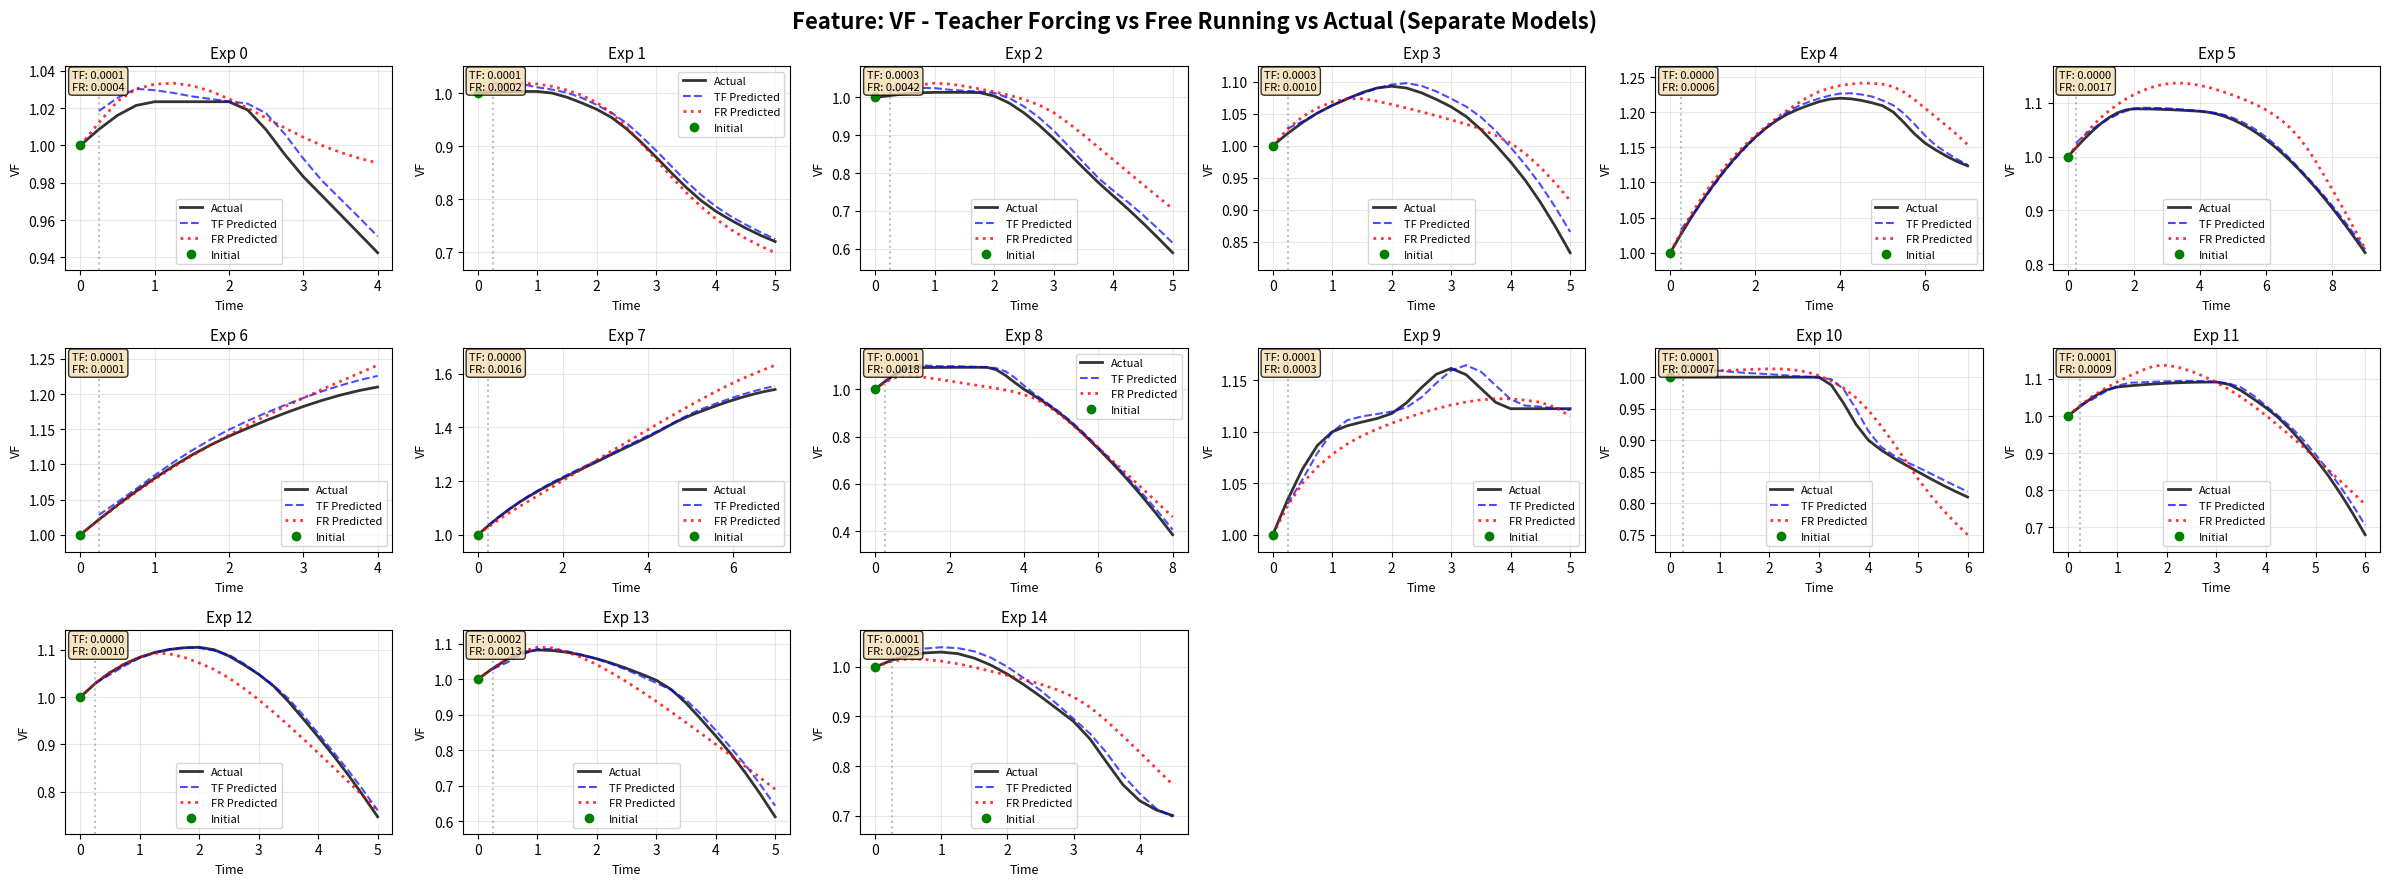

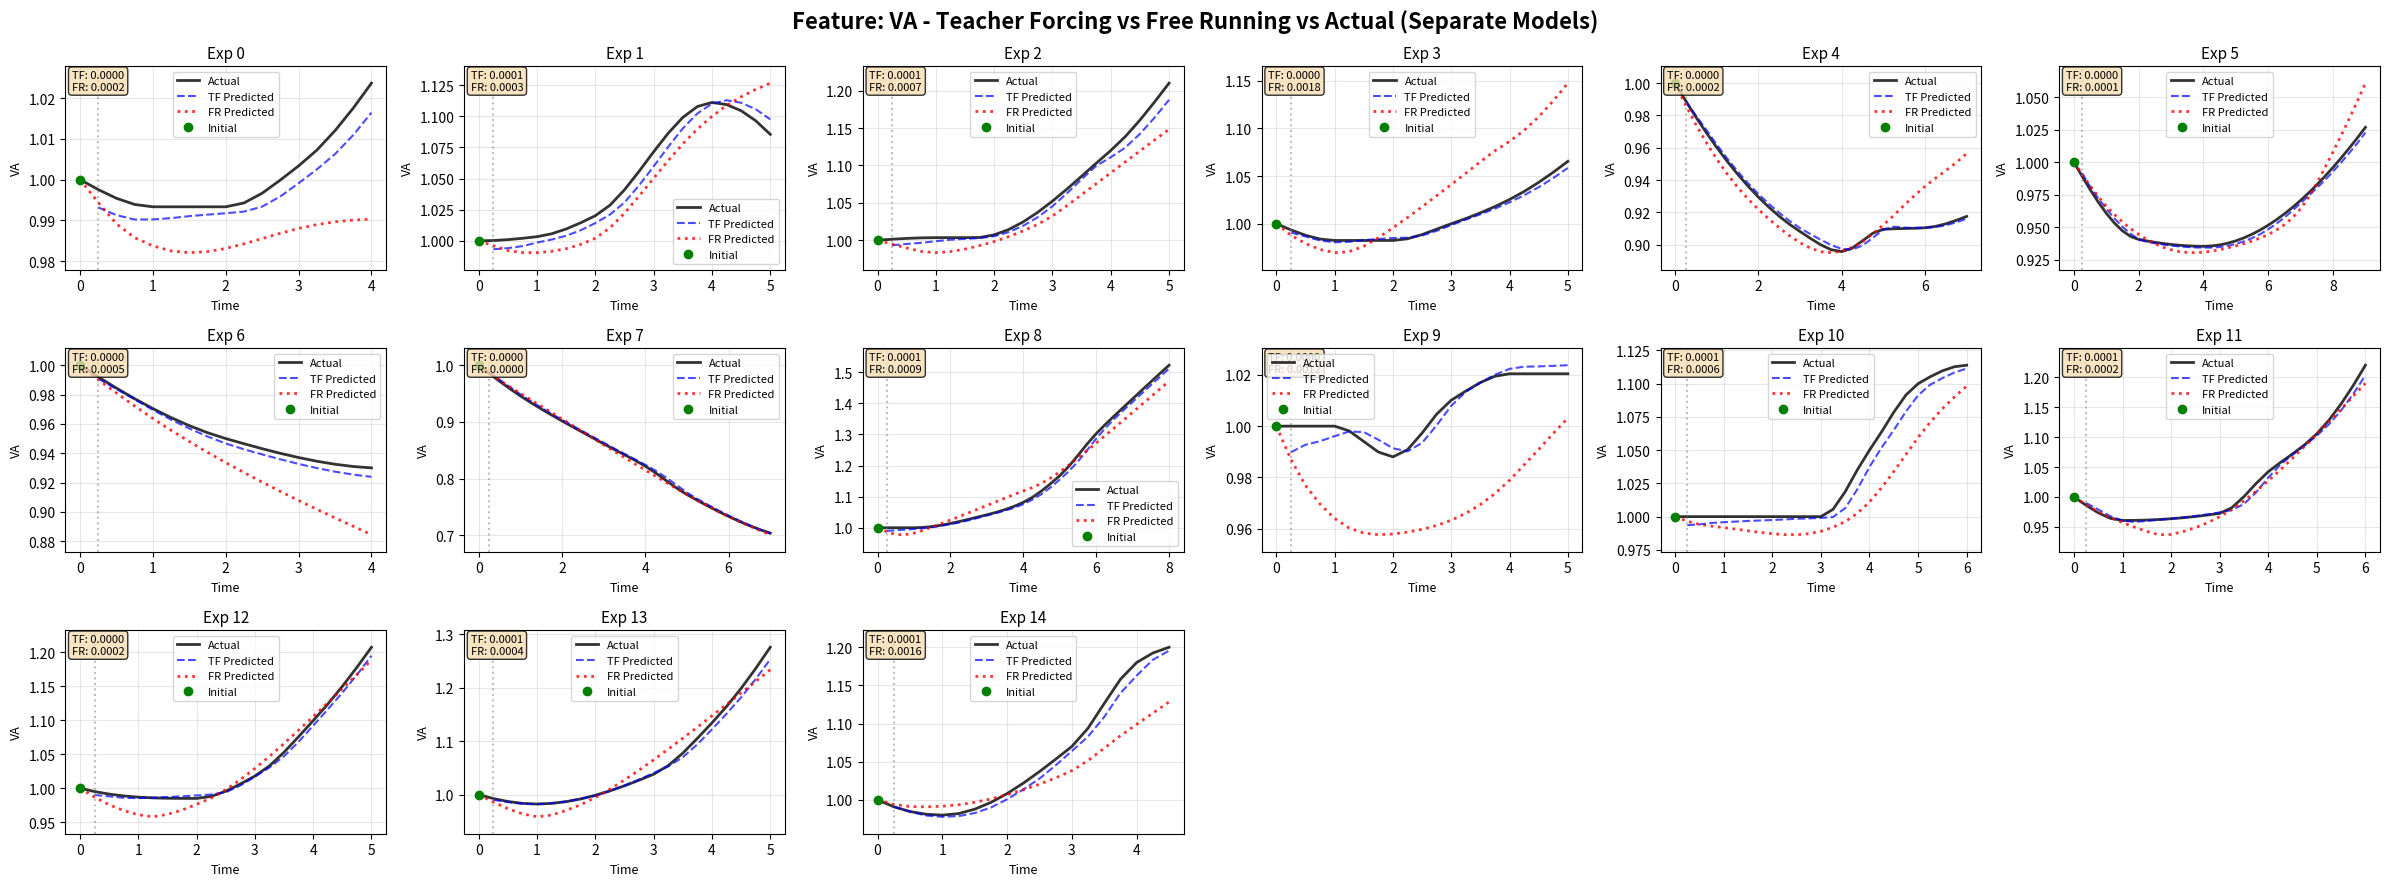

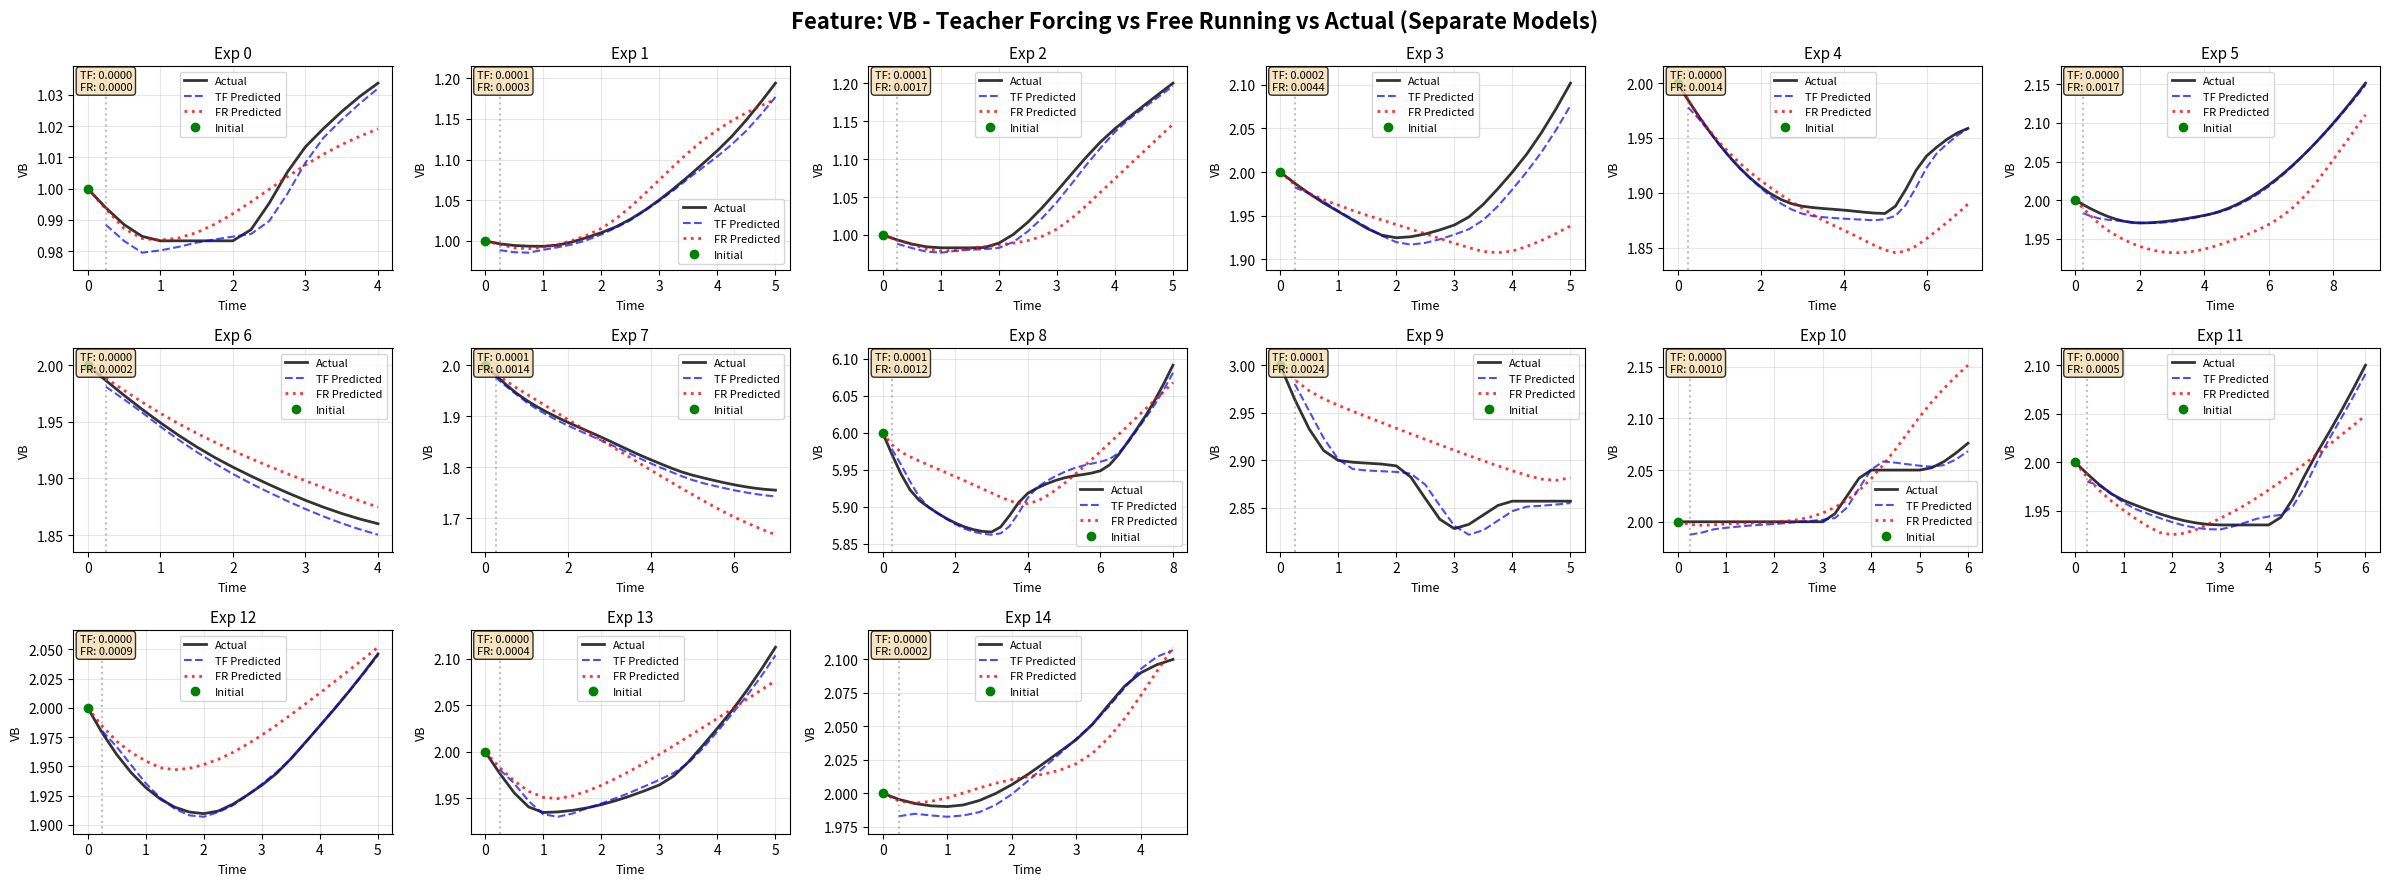

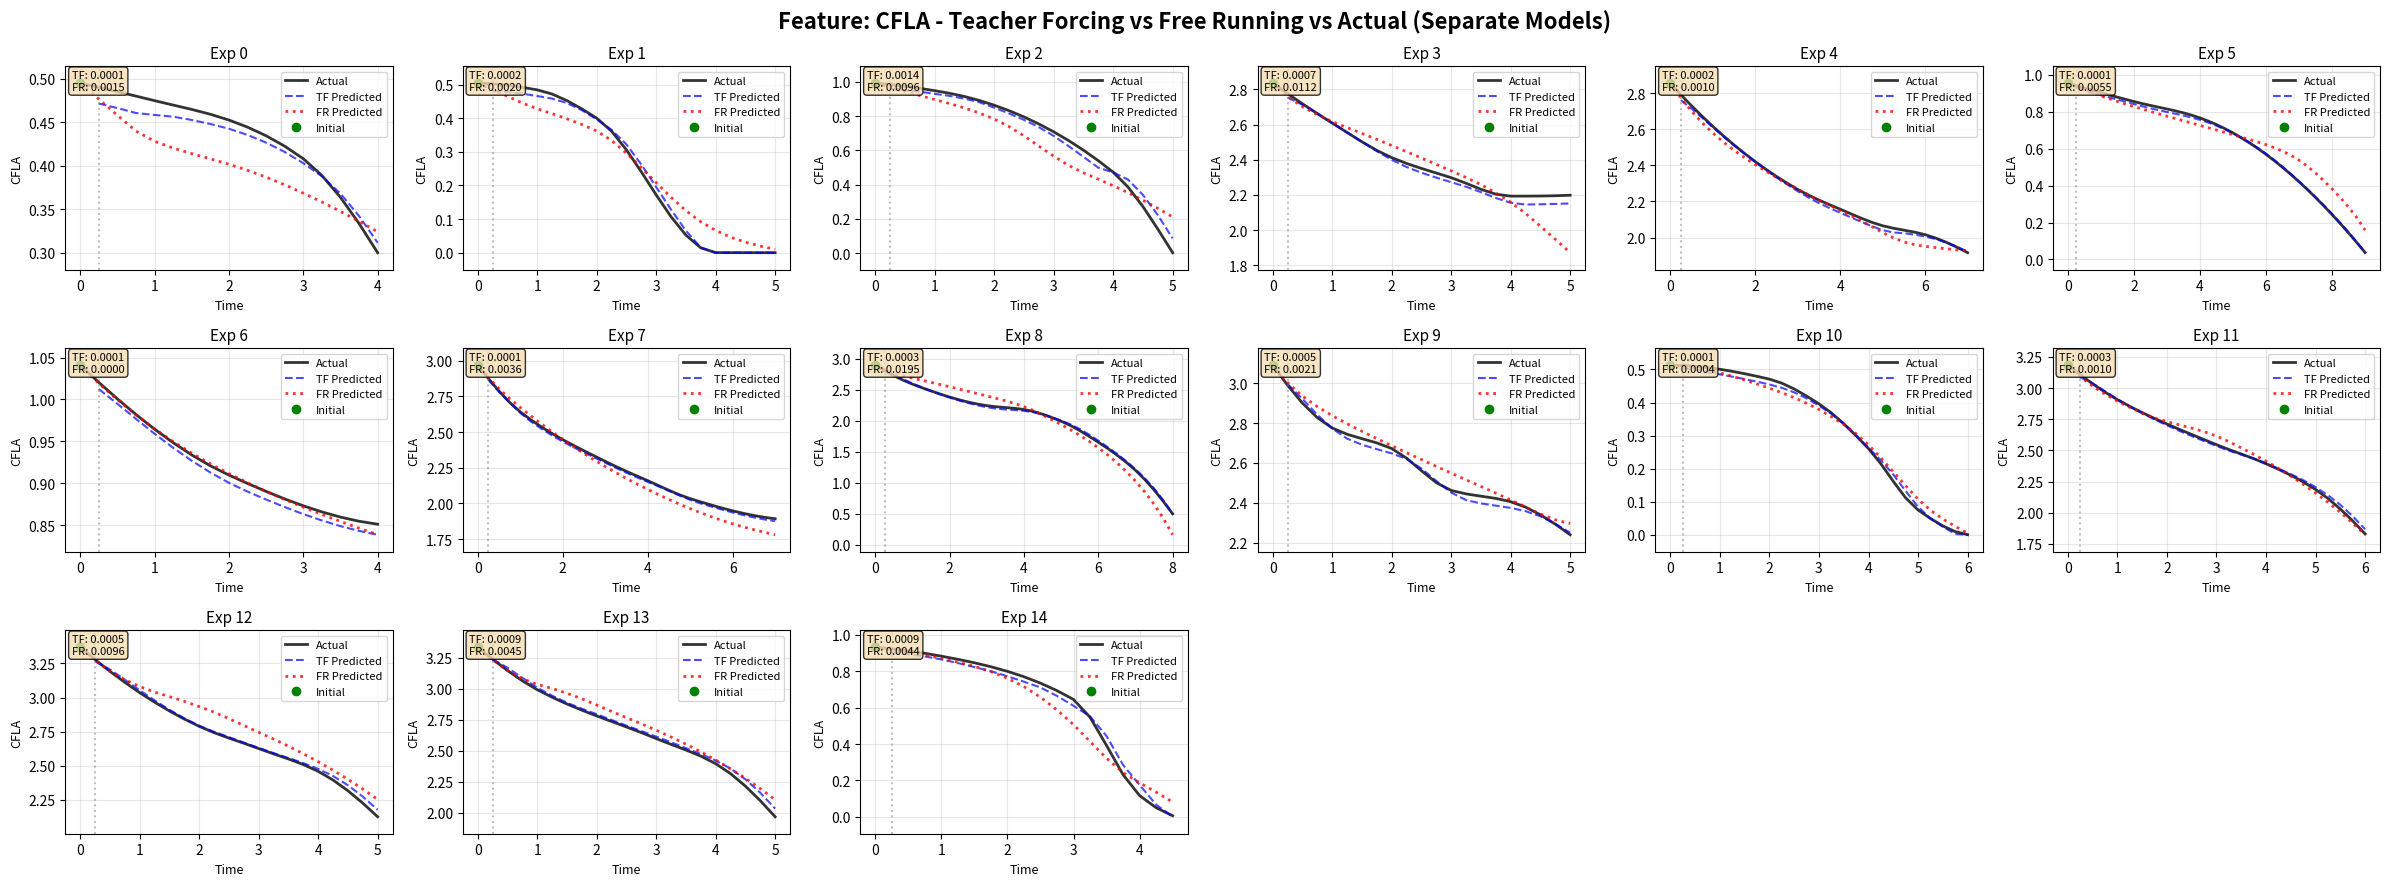

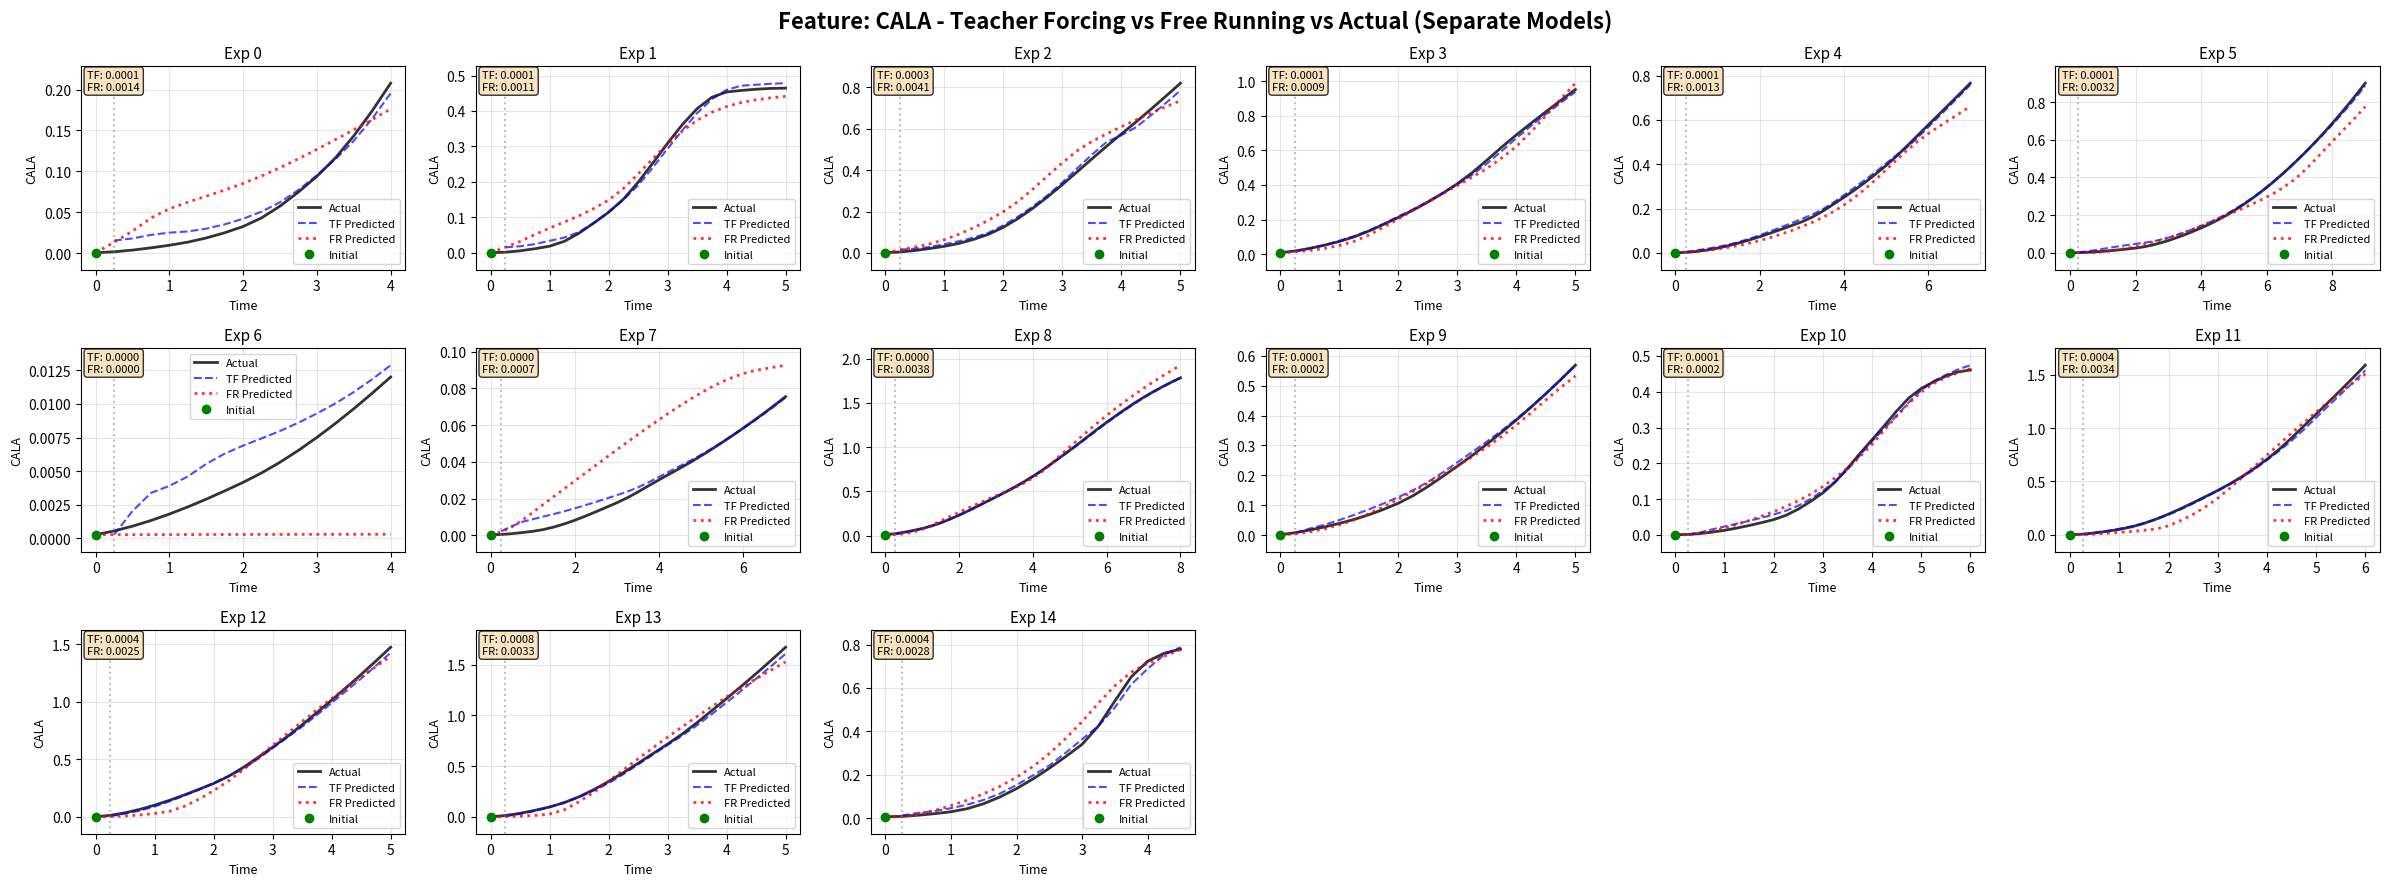

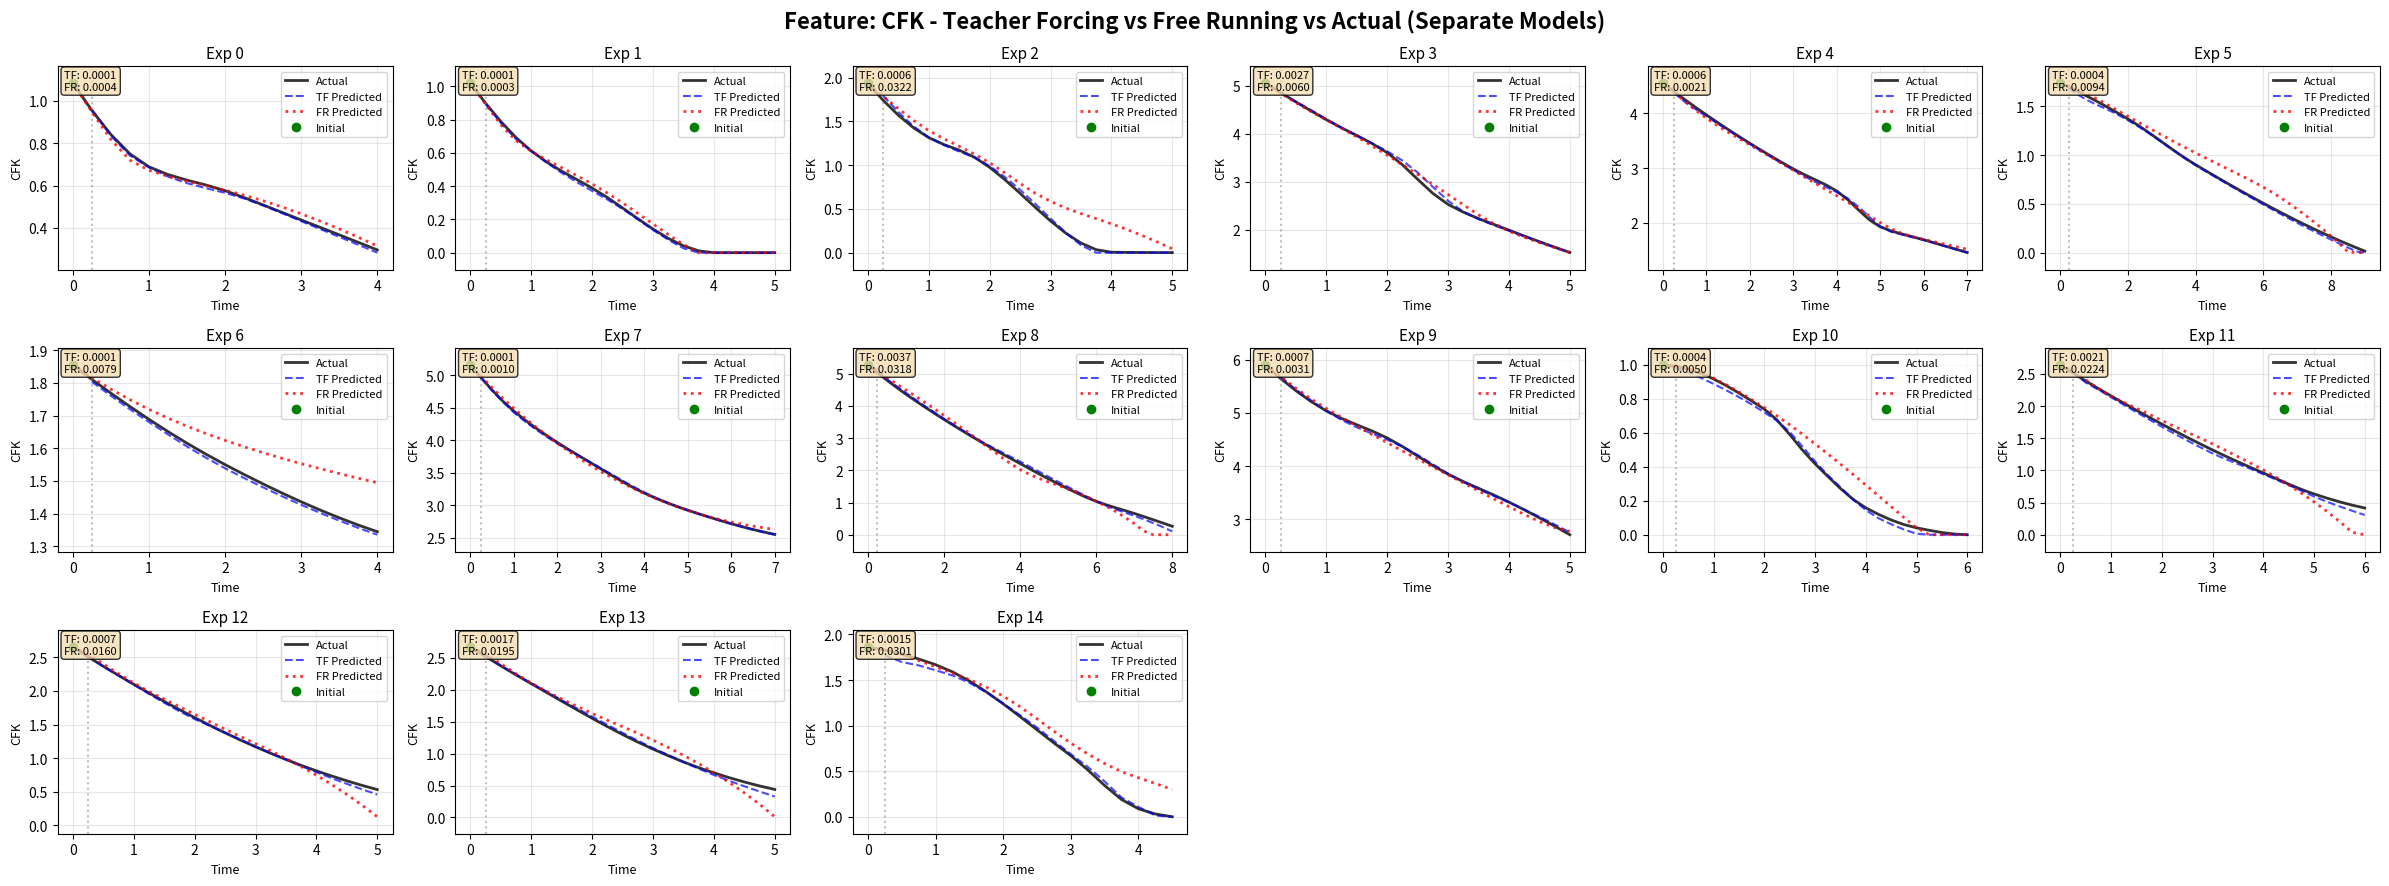

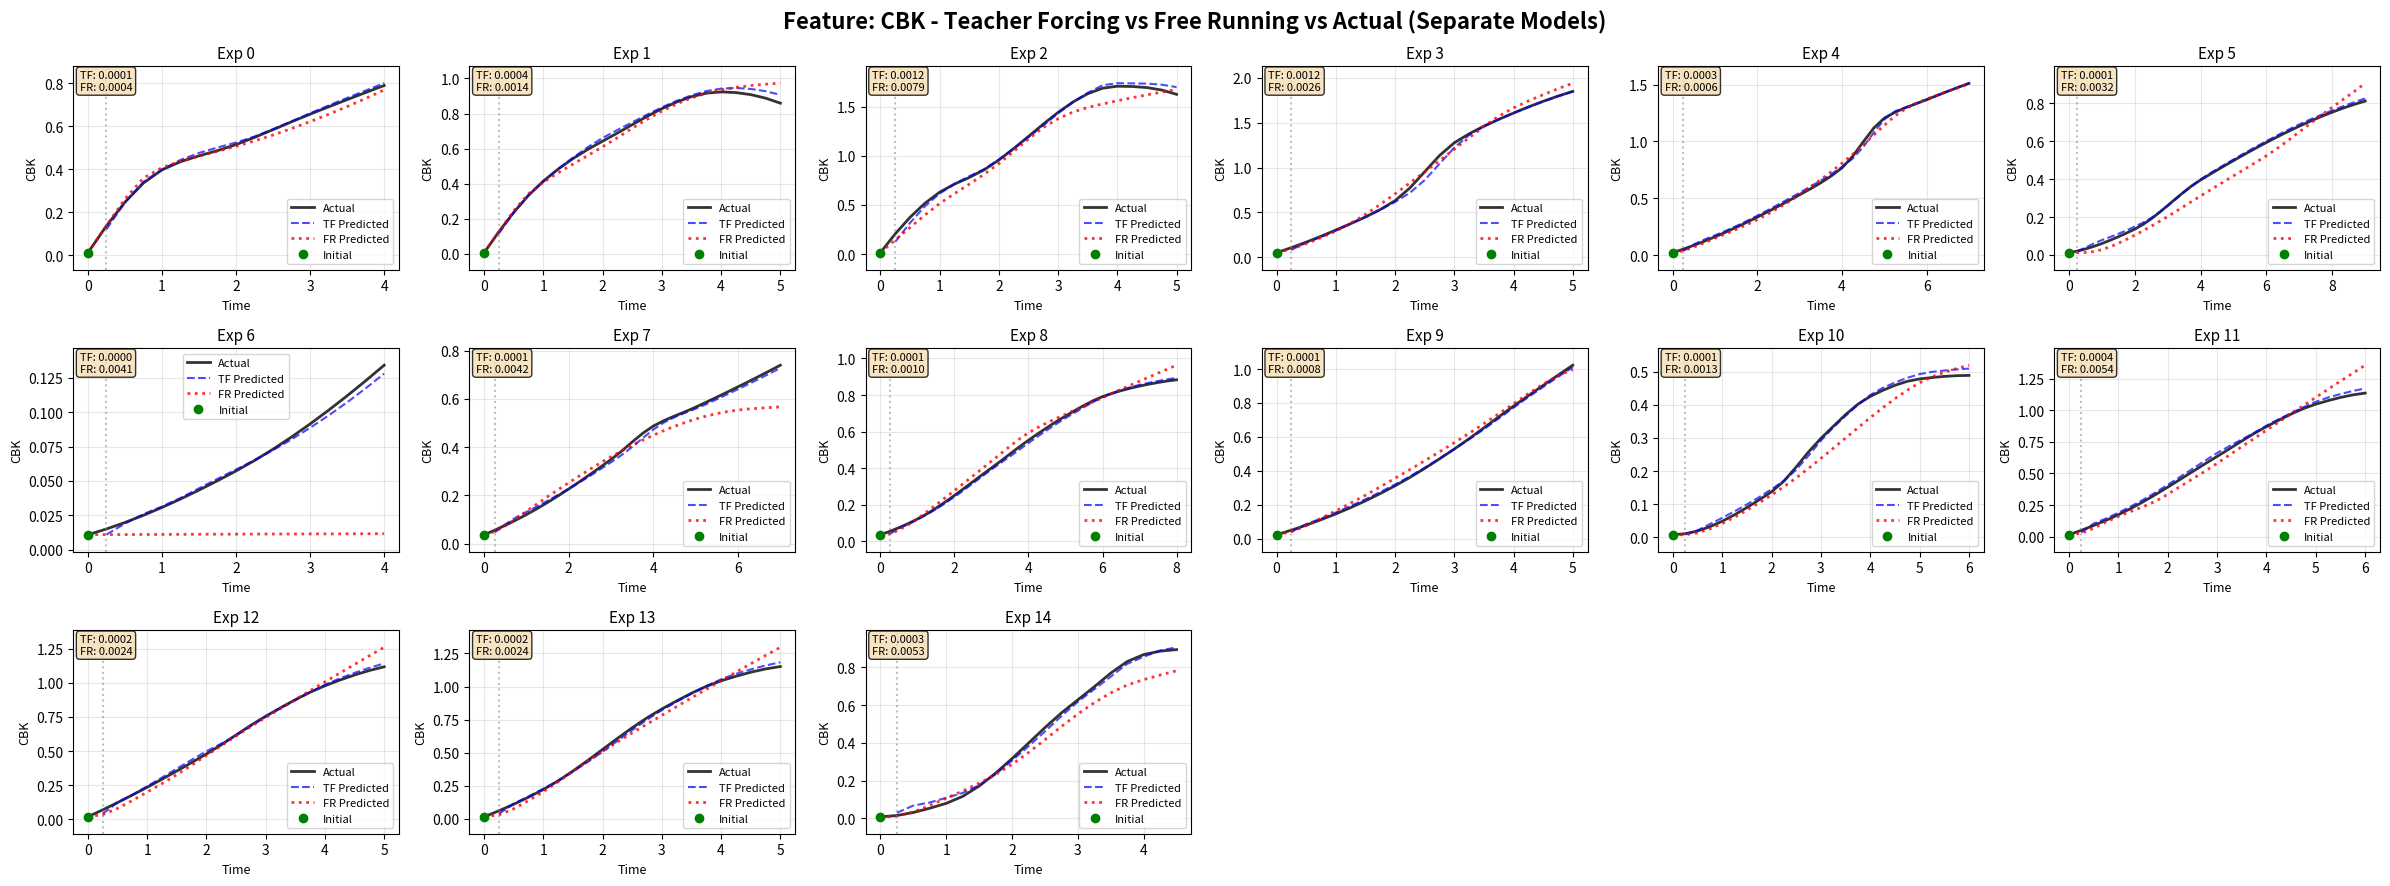

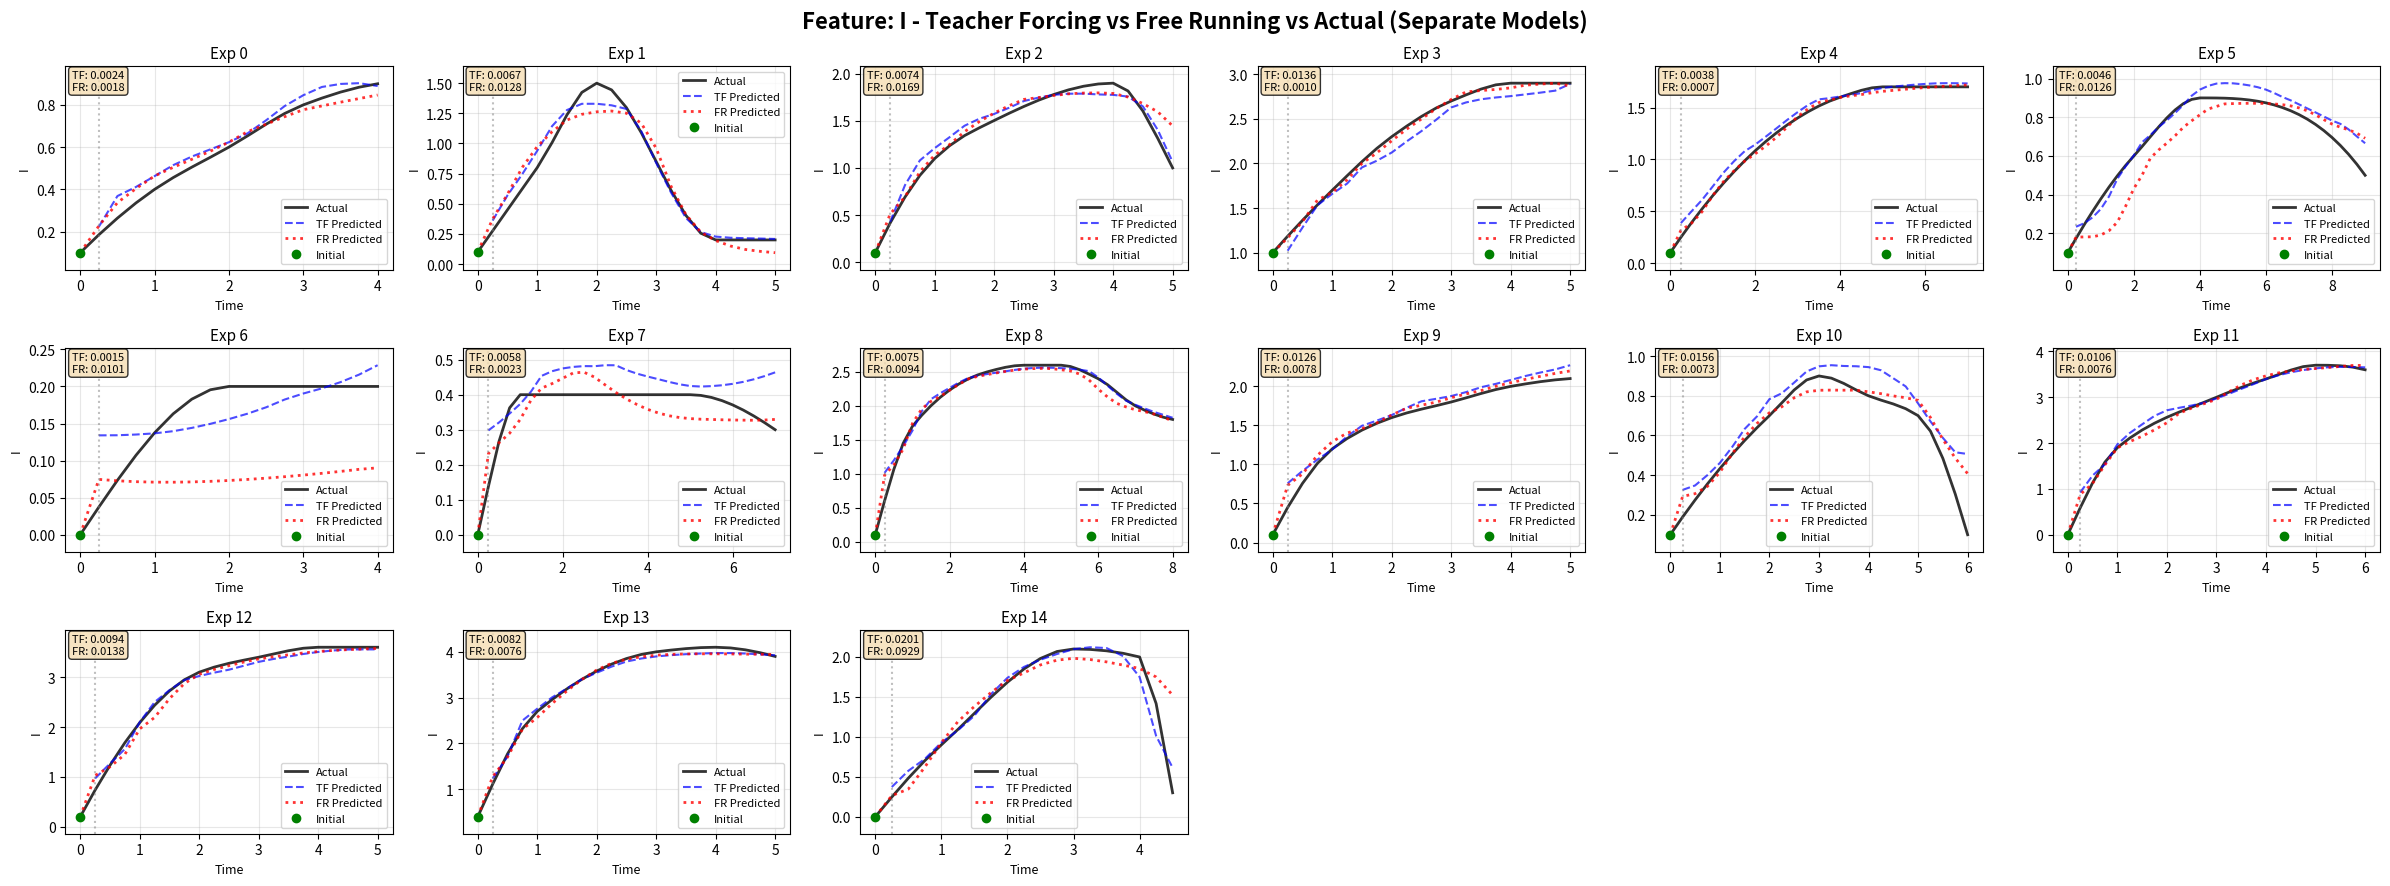

üéâ Î™®Îì† featureÏóê ÎåÄÌïú Teacher Forcing vs Free Running ÎπÑÍµê Í∑∏ÎûòÌîÑ ÏÉùÏÑ± ÏôÑÎ£å!
üìä Í∑∏ÎûòÌîÑ ÏÑ§Î™Ö:
   - Í≤ÄÏùÄÏÉâ Ïã§ÏÑ†: Ïã§Ï†úÍ∞í (Actual)
   - ÌååÎûÄÏÉâ Ï†êÏÑ†: Teacher Forcing ÏòàÏ∏°Í∞í (BMED_TF_250909.pth Î™®Îç∏ ÏÇ¨Ïö©)
   - Îπ®Í∞ÑÏÉâ Ï†êÏÑ†: Free Running ÏòàÏ∏°Í∞í (BMED_FR_250909.pth Î™®Îç∏ ÏÇ¨Ïö©)
   - Ï¥àÎ°ùÏÉâ Ï†ê: Ï¥àÍ∏∞Í∞í
   - ÌöåÏÉâ ÏàòÏßÅÏÑ†: ÏòàÏ∏° ÏãúÏûëÏ†ê
   - Í∞Å subplot: Í∞úÎ≥Ñ Ïã§Ìóò Í≤∞Í≥º
   - V, E Ï†úÏô∏Ìïú 8Í∞ú feature Î™®Îëê ÌëúÏãú
   üéØ TF Î™®Îç∏Í≥º FR Î™®Îç∏ÏùÑ Í∞ÅÍ∞Å ÏÇ¨Ïö©ÌïòÏó¨ Ï†ïÌôïÌïú ÎπÑÍµê Î∂ÑÏÑù!


In [ ]:
# Teacher Forcing vs Free Running Ï†ÑÏ≤¥ Ïã§Ìóò ÎπÑÍµê ÏãúÍ∞ÅÌôî - FeatureÎ≥Ñ Subplot (Í∞ÅÍ∞ÅÏùò Î™®Îç∏ ÏÇ¨Ïö©)

print("üéØ Teacher Forcing vs Free Running Ï†ÑÏ≤¥ Ïã§Ìóò ÎπÑÍµê ÏãúÍ∞ÅÌôî (Í∞ÅÍ∞ÅÏùò Î™®Îç∏ ÏÇ¨Ïö©)")
print("="*60)

# Teacher Forcing Ï†ÑÏö© Î™®Îç∏ Î°úÎìú
print("üì• Teacher Forcing Î™®Îç∏ Î°úÎìú Ï§ë: BMED_TF_250909.pth")
tf_checkpoint = torch.load("BMED_TF_250909.pth", map_location=device, weights_only=False)
tf_model = BMEDAutoregressiveModel(
    state_extr_params=tf_checkpoint['model_config']['state_extr_params'],
    decoder_params=tf_checkpoint['model_config']['decoder_params'],
    current_predictor_params=tf_checkpoint['model_config']['current_predictor_params'],
    range_mm=tf_checkpoint['model_config']['range_mm']
).to(device)
tf_model.load_state_dict(tf_checkpoint['model_state_dict'])
tf_model.eval()
print("‚úÖ Teacher Forcing Î™®Îç∏ Î°úÎìú ÏôÑÎ£å!")

# Free Running Ï†ÑÏö© Î™®Îç∏ Î°úÎìú
print("üì• Free Running Î™®Îç∏ Î°úÎìú Ï§ë: BMED_FR_250910.pth")
fr_checkpoint = torch.load("BMED_FR_250910.pth", map_location=device, weights_only=False)
fr_model = BMEDAutoregressiveModel(
    state_extr_params=fr_checkpoint['model_config']['state_extr_params'],
    decoder_params=fr_checkpoint['model_config']['decoder_params'],
    current_predictor_params=fr_checkpoint['model_config']['current_predictor_params'],
    range_mm=fr_checkpoint['model_config']['range_mm']
).to(device)
fr_model.load_state_dict(fr_checkpoint['model_state_dict'])
fr_model.eval()
print("‚úÖ Free Running Î™®Îç∏ Î°úÎìú ÏôÑÎ£å!")

# ‚úÖ ÌòÑÏû¨ Îç∞Ïù¥ÌÑ∞Ïùò range_mmÏùÑ ÏÇ¨Ïö©ÌïòÏó¨ ÎπÑÏ†ïÍ∑úÌôî Ìï®Ïàò Ï†ïÏùò
def denormalize_data(normalized_data, feature_name):
    """ÌòÑÏû¨ Îç∞Ïù¥ÌÑ∞ Í∏∞Ï§Ä Ï†ïÍ∑úÌôîÎêú Îç∞Ïù¥ÌÑ∞Î•º ÏõêÎûò Îã®ÏúÑÎ°ú Î≥µÏõê"""
    if feature_name in range_mm:
        min_val = range_mm[feature_name]['min']
        max_val = range_mm[feature_name]['max']
        return normalized_data * (max_val - min_val) + min_val
    return normalized_data

# ÏòàÏ∏° Í≤∞Í≥ºÏôÄ Ïã§Ï†ú Í∞íÏùÑ Ï†ÄÏû•Ìï† ÎîïÏÖîÎÑàÎ¶¨
tf_predictions_dict = {}
fr_predictions_dict = {}
actual_dict = {}

# VÏôÄ EÎ•º Ï†úÏô∏Ìïú featureÎì§Ïùò Ïù∏Îç±Ïä§ÏôÄ Ïù¥Î¶Ñ
feature_names = ['VF', 'VA', 'VB', 'CFLA', 'CALA', 'CFK', 'CBK', 'I']
feature_indices = [2, 3, 4, 5, 6, 7, 8, 9]  # V(0), E(1)Î•º Ï†úÏô∏Ìïú Ïù∏Îç±Ïä§

# Ï†ÑÏ≤¥ Ïã§ÌóòÏóê ÎåÄÌï¥ ÏòàÏ∏° ÏàòÌñâ
with torch.no_grad():
    for exp_num in exp_num_list:
        # Ïã§Ìóò Îç∞Ïù¥ÌÑ∞ Ï∂îÏ∂ú
        exp_data = ndf[ndf['exp'] == exp_num].copy()
        if len(exp_data) == 0:
            continue
        
        # ÌäπÏÑ± Ïª¨ÎüºÎì§
        feature_cols = ['V', 'E', 'VF', 'VA', 'VB', 'CFLA', 'CALA', 'CFK', 'CBK', 'I']
        
        # Ïã§Ìóò Îç∞Ïù¥ÌÑ∞Î•º tensorÎ°ú Î≥ÄÌôò
        exp_tensor = torch.tensor(exp_data[feature_cols].values).float().unsqueeze(0).to(device)  # [1, seq_len, 10]
        seq_length = len(exp_data)
        seq_len_tensor = torch.tensor([seq_length]).to(device)
        
        # Teacher Forcing Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ Î∞è ÏòàÏ∏° (TF Ï†ÑÏö© Î™®Îç∏ ÏÇ¨Ïö©)
        tf_inputs, tf_targets, tf_seq_len = tf_data(exp_tensor, seq_len_tensor)
        tf_pred = tf_model(tf_inputs, tf_seq_len, mode='teacher_forcing')
        
        # Free Running Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ Î∞è ÏòàÏ∏° (FR Ï†ÑÏö© Î™®Îç∏ ÏÇ¨Ïö©)
        fr_initial_states, fr_targets, fr_lengths = fr_data(exp_tensor, seq_len_tensor)
        initial_state = fr_initial_states  # [1, 10]
        target_length = int(fr_lengths[0].item())
        fr_pred = fr_model(initial_state, mode='free_running', target_length=target_length)
        
        # CPUÎ°ú Ïù¥ÎèôÌïòÍ≥† numpy Î≥ÄÌôò
        tf_pred_np = tf_pred[0].cpu().numpy()  # [seq_len-1, 10]
        fr_pred_np = fr_pred[0].cpu().numpy()  # [seq_len, 10]
        actual_tf_np = tf_targets[0].cpu().numpy()  # [seq_len-1, 10] (TF targets)
        actual_fr_np = fr_targets[0, :target_length].cpu().numpy()  # [seq_len, 10] (FR targets)
        
        # ÎîïÏÖîÎÑàÎ¶¨Ïóê Ï†ÄÏû•
        tf_predictions_dict[exp_num] = tf_pred_np
        fr_predictions_dict[exp_num] = fr_pred_np
        actual_dict[exp_num] = {
            'tf': actual_tf_np,  # Teacher Forcing ÌÉÄÍ≤ü (ÏãúÏ†ê 1Î∂ÄÌÑ∞)
            'fr': actual_fr_np,  # Free Running ÌÉÄÍ≤ü (Ï†ÑÏ≤¥ ÏãúÌÄÄÏä§)
            'time_tf': exp_data['t'].values[1:len(tf_pred_np)+1],  # TF ÏãúÍ∞ÑÏ∂ï
            'time_fr': exp_data['t'].values[:len(fr_pred_np)]      # FR ÏãúÍ∞ÑÏ∂ï
        }

print(f"‚úÖ {len(tf_predictions_dict)}Í∞ú Ïã§ÌóòÏóê ÎåÄÌïú ÏòàÏ∏° ÏôÑÎ£å")

# VÏôÄ EÎ•º Ï†úÏô∏Ìïú Í∞Å featureÎ≥ÑÎ°ú Í∑∏ÎûòÌîÑ ÏÉùÏÑ±
for feat_idx, feat_name in zip(feature_indices, feature_names):
    # subplot Í∞úÏàò Í≥ÑÏÇ∞ (ÌñâÍ≥º Ïó¥ ÏµúÏ†ÅÌôî)
    n_experiments = len(exp_num_list)
    n_cols = min(6, n_experiments)  # ÏµúÎåÄ 6Ïó¥
    n_rows = (n_experiments + n_cols - 1) // n_cols  # ÌïÑÏöîÌïú Ìñâ Ïàò
    
    # Í∑∏ÎûòÌîÑ ÌÅ¨Í∏∞ ÏÑ§Ï†ï
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))
    fig.suptitle(f'Feature: {feat_name} - Teacher Forcing vs Free Running vs Actual (Separate Models)', fontsize=16, fontweight='bold')
    
    # subplotÏù¥ 1Í∞úÏùº Í≤ΩÏö∞ Î¶¨Ïä§Ìä∏Î°ú Î≥ÄÌôò
    if n_experiments == 1:
        axes = [axes]
    elif n_rows == 1:
        axes = axes.reshape(1, -1)
    
    # Í∞Å Ïã§ÌóòÏóê ÎåÄÌï¥ subplot ÏÉùÏÑ±
    for i, exp_num in enumerate(exp_num_list):
        row = i // n_cols
        col = i % n_cols
        
        if n_rows > 1:
            ax = axes[row, col]
        else:
            ax = axes[col] if n_cols > 1 else axes[0]
        
        # ÏòàÏ∏°Í∞íÍ≥º Ïã§Ï†úÍ∞í Í∞ÄÏ†∏Ïò§Í∏∞ (ÌòÑÏû¨ Îç∞Ïù¥ÌÑ∞ range_mmÏúºÎ°ú ÎπÑÏ†ïÍ∑úÌôî)
        if exp_num in tf_predictions_dict:
            tf_pred_values = denormalize_data(tf_predictions_dict[exp_num][:, feat_idx], feat_name)
            fr_pred_values = denormalize_data(fr_predictions_dict[exp_num][:, feat_idx], feat_name)
            tf_actual_values = denormalize_data(actual_dict[exp_num]['tf'][:, feat_idx], feat_name)
            fr_actual_values = denormalize_data(actual_dict[exp_num]['fr'][:, feat_idx], feat_name)
            tf_time = actual_dict[exp_num]['time_tf'][:len(tf_pred_values)]
            fr_time = actual_dict[exp_num]['time_fr'][:len(fr_pred_values)]
            
            # Í∑∏ÎûòÌîÑ Í∑∏Î¶¨Í∏∞
            # Ïã§Ï†úÍ∞í (Free RunningÏùÄ Ï†ÑÏ≤¥, Teacher ForcingÏùÄ ÏãúÏ†ê 1Î∂ÄÌÑ∞)
            ax.plot(fr_time, fr_actual_values, 'k-', linewidth=2, label='Actual', alpha=0.8)
            
            # Teacher Forcing ÏòàÏ∏° (ÏãúÏ†ê 1Î∂ÄÌÑ∞)
            ax.plot(tf_time, tf_pred_values, 'b--', linewidth=1.5, label='TF Predicted', alpha=0.7)
            
            # Free Running ÏòàÏ∏° (Ï†ÑÏ≤¥ ÏãúÌÄÄÏä§)
            ax.plot(fr_time, fr_pred_values, 'r:', linewidth=2, label='FR Predicted', alpha=0.8)
            
            # Ï¥àÍ∏∞Í∞í ÌëúÏãú
            if len(fr_actual_values) > 0:
                ax.plot(fr_time[0], fr_actual_values[0], 'go', markersize=6, label='Initial')
            
            # ÏòàÏ∏° ÏãúÏûëÏ†ê ÌëúÏãú
            if len(fr_time) > 1:
                ax.axvline(x=fr_time[1], color='gray', linestyle=':', alpha=0.5)
            
            # Í∑∏ÎûòÌîÑ ÏÑ§Ï†ï
            ax.set_title(f'Exp {exp_num}', fontsize=11)
            ax.set_xlabel('Time', fontsize=9)
            ax.set_ylabel(feat_name, fontsize=9)
            ax.grid(True, alpha=0.3)
            ax.legend(fontsize=8)
            
            # MSE Í≥ÑÏÇ∞ Î∞è ÌëúÏãú (ÎπÑÏ†ïÍ∑úÌôîÎêú Í∞íÏúºÎ°ú)
            tf_mse = np.mean((tf_actual_values - tf_pred_values)**2) if len(tf_pred_values) > 0 else 0
            fr_mse = np.mean((fr_actual_values - fr_pred_values)**2) if len(fr_pred_values) > 0 else 0
            
            # ÌÖçÏä§Ìä∏ Î∞ïÏä§Î°ú MSE ÌëúÏãú
            textstr = f'TF: {tf_mse:.4f}\nFR: {fr_mse:.4f}'
            ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=8,
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
            
            # yÏ∂ï Î≤îÏúÑ ÏÑ§Ï†ï
            all_values = np.concatenate([tf_actual_values, fr_actual_values, tf_pred_values, fr_pred_values])
            y_min, y_max = all_values.min(), all_values.max()
            y_range = y_max - y_min
            if y_range > 0:
                ax.set_ylim(y_min - 0.1*y_range, y_max + 0.1*y_range)
        else:
            ax.text(0.5, 0.5, f'No data\nExp {exp_num}', 
                   ha='center', va='center', transform=ax.transAxes, fontsize=12)
            ax.set_xticks([])
            ax.set_yticks([])
    
    # Îπà subplot Ï†úÍ±∞
    for i in range(n_experiments, n_rows * n_cols):
        row = i // n_cols
        col = i % n_cols
        if n_rows > 1:
            axes[row, col].remove()
        else:
            if n_cols > 1:
                axes[col].remove()
    
    plt.tight_layout()
    plt.show()

print("üéâ Î™®Îì† featureÏóê ÎåÄÌïú Teacher Forcing vs Free Running ÎπÑÍµê Í∑∏ÎûòÌîÑ ÏÉùÏÑ± ÏôÑÎ£å!")
print("üìä Í∑∏ÎûòÌîÑ ÏÑ§Î™Ö:")
print("   - Í≤ÄÏùÄÏÉâ Ïã§ÏÑ†: Ïã§Ï†úÍ∞í (Actual)")
print("   - ÌååÎûÄÏÉâ Ï†êÏÑ†: Teacher Forcing ÏòàÏ∏°Í∞í (BMED_TF_250909.pth Î™®Îç∏ ÏÇ¨Ïö©)")
print("   - Îπ®Í∞ÑÏÉâ Ï†êÏÑ†: Free Running ÏòàÏ∏°Í∞í (BMED_FR_250909.pth Î™®Îç∏ ÏÇ¨Ïö©)")
print("   - Ï¥àÎ°ùÏÉâ Ï†ê: Ï¥àÍ∏∞Í∞í")
print("   - ÌöåÏÉâ ÏàòÏßÅÏÑ†: ÏòàÏ∏° ÏãúÏûëÏ†ê")
print("   - Í∞Å subplot: Í∞úÎ≥Ñ Ïã§Ìóò Í≤∞Í≥º")
print("   - V, E Ï†úÏô∏Ìïú 8Í∞ú feature Î™®Îëê ÌëúÏãú")
print("   üéØ TF Î™®Îç∏Í≥º FR Î™®Îç∏ÏùÑ Í∞ÅÍ∞Å ÏÇ¨Ïö©ÌïòÏó¨ Ï†ïÌôïÌïú ÎπÑÍµê Î∂ÑÏÑù!")